In [3]:
# ==========================================
# Control model (LGBM) + Baselines (NO FILE OUTPUT)
# Target week: 2026-01-05
# Predict:
#   - trip_cnt_per_user
#   - nonrepeat_cnt_per_user
# ==========================================

import numpy as np
import pandas as pd

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260119_control.csv"
TARGET_WEEK = "2026-01-05"

# 控制組：只關心 ops_type_merged, city_group
CAT_COLS = ["ops_type_merged", "city_group"]
DATE_COL = "experiment_date"

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

# Baselines (必須在資料裡存在)
Y1_LAG1 = "trip_cnt_per_user_lag1"
Y1_ROLL4 = "trip_cnt_per_user_roll4"
Y2_LAG1 = "nonrepeat_cnt_per_user_lag1"
Y2_ROLL4 = "nonrepeat_cnt_per_user_roll4"

# ✅ 你不想放入模型的變數
DROP_FEATURES = {"log1p_user_cnt"}

RANDOM_STATE = 42

# --------------------------
# Helpers
# --------------------------
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def make_time_val_split(train_df, date_col, n_val_weeks=4):
    """
    用 train 資料中最後 n_val_weeks 個 unique 週當 validation（時間切分）
    """
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None

    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])

    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()

    # fallback：若切不到就改 80/20 by date
    if tr.empty or va.empty:
        cut = int(len(uniq_dates) * 0.8)
        cut = max(1, min(cut, len(uniq_dates) - 1))
        tr_dates = set(uniq_dates[:cut])
        va_dates = set(uniq_dates[cut:])
        tr = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(tr_dates)].copy()
        va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(va_dates)].copy()
        if tr.empty or va.empty:
            return train_df.copy(), None

    return tr, va

def drop_constant_features(train_df, feature_cols):
    """
    移除在 train 期間完全沒有變化的欄位（控制組常見：treatment/source 全常數）
    """
    keep = []
    dropped = []
    for c in feature_cols:
        nun = train_df[c].nunique(dropna=False)
        if nun <= 1:
            dropped.append(c)
        else:
            keep.append(c)
    return keep, dropped

# --------------------------
# Load & preprocess
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

if df[DATE_COL].isna().any():
    bad = df[df[DATE_COL].isna()].head(10)
    raise ValueError(f"Found unparsable dates in {DATE_COL}. Examples:\n{bad}")

required_cols = CAT_COLS + [DATE_COL, Y1, Y2, Y1_LAG1, Y1_ROLL4, Y2_LAG1, Y2_ROLL4]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

for c in CAT_COLS:
    df[c] = df[c].astype("category")

# 用 week_idx 取代把日期直接丟進模型（比較穩）
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

target_week = pd.to_datetime(TARGET_WEEK)

# --------------------------
# Split train / test (time-based)
# --------------------------
train = df[df[DATE_COL] < target_week].copy()
test = df[df[DATE_COL] == target_week].copy()

if train.empty:
    raise ValueError("Train set is empty. TARGET_WEEK may be too early.")
if test.empty:
    raise ValueError(f"Test set is empty for week {TARGET_WEEK}. Check experiment_date values.")

print("=== Target week ===", TARGET_WEEK)
print("Train rows:", len(train), "| Test rows:", len(test))
print("Train weeks:", train[DATE_COL].dt.date.nunique(), "| Test weeks:", test[DATE_COL].dt.date.nunique())
print("Test ops_type_merged:", test["ops_type_merged"].nunique(), "| Test city_group:", test["city_group"].nunique())

# --------------------------
# Baseline predictions (直接用 lag/roll 當預測)
# --------------------------
test["pred_y1_lag1"] = test[Y1_LAG1].astype(float)
test["pred_y1_roll4"] = test[Y1_ROLL4].astype(float)
test["pred_y2_lag1"] = test[Y2_LAG1].astype(float)
test["pred_y2_roll4"] = test[Y2_ROLL4].astype(float)

# --------------------------
# Feature matrix: 用「除了 y 以外」全部欄位當特徵
# 並把 experiment_date 拿掉（保留 week_idx）
# ✅ 同時移除 log1p_user_cnt
# ✅ 控制組額外：自動移除 train 期間的常數欄位
# --------------------------
exclude = {Y1, Y2} | set(DROP_FEATURES)

feature_cols = [c for c in df.columns if c not in exclude]
if DATE_COL in feature_cols:
    feature_cols.remove(DATE_COL)

# 控制組常見：treatment/source 之類可能全常數，先自動移掉
feature_cols, dropped_const = drop_constant_features(train, feature_cols)
if dropped_const:
    print("\n[Info] Dropped constant features in train:", dropped_const)

cat_features = [c for c in CAT_COLS if c in feature_cols]

X_train = train[feature_cols].copy()
X_test = test[feature_cols].copy()

y1_train = train[Y1].astype(float).values
y2_train = train[Y2].astype(float).values

y1_true = test[Y1].astype(float).values
y2_true = test[Y2].astype(float).values

# --------------------------
# Time-based validation for early stopping
# --------------------------
tr_df, va_df = make_time_val_split(train, DATE_COL, n_val_weeks=4)
X_tr = tr_df[feature_cols].copy()
y1_tr = tr_df[Y1].astype(float).values
y2_tr = tr_df[Y2].astype(float).values

X_va = y1_va = y2_va = None
if va_df is not None:
    X_va = va_df[feature_cols].copy()
    y1_va = va_df[Y1].astype(float).values
    y2_va = va_df[Y2].astype(float).values

# --------------------------
# Train LGBM (global) — 兩個 target 各一個模型
# --------------------------
import lightgbm as lgb

common_params = dict(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    force_row_wise=True,
)

m_y1 = lgb.LGBMRegressor(**common_params)
m_y2 = lgb.LGBMRegressor(**common_params)

fit_kwargs = dict(categorical_feature=cat_features)

if X_va is not None:
    m_y1.fit(
        X_tr, y1_tr,
        eval_set=[(X_va, y1_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        **fit_kwargs
    )
    m_y2.fit(
        X_tr, y2_tr,
        eval_set=[(X_va, y2_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        **fit_kwargs
    )
else:
    m_y1.fit(X_train, y1_train, **fit_kwargs)
    m_y2.fit(X_train, y2_train, **fit_kwargs)

# Predict on target week
test["pred_y1_lgbm"] = m_y1.predict(X_test)
test["pred_y2_lgbm"] = m_y2.predict(X_test)

# --------------------------
# Overall metrics
# --------------------------
metrics_df = pd.DataFrame([
    {"target": Y1, "model": "baseline_lag1",  "MAE": mae(y1_true, test["pred_y1_lag1"]),   "RMSE": rmse(y1_true, test["pred_y1_lag1"])},
    {"target": Y1, "model": "baseline_roll4", "MAE": mae(y1_true, test["pred_y1_roll4"]),  "RMSE": rmse(y1_true, test["pred_y1_roll4"])},
    {"target": Y1, "model": "lgbm_global",    "MAE": mae(y1_true, test["pred_y1_lgbm"]),   "RMSE": rmse(y1_true, test["pred_y1_lgbm"])},

    {"target": Y2, "model": "baseline_lag1",  "MAE": mae(y2_true, test["pred_y2_lag1"]),   "RMSE": rmse(y2_true, test["pred_y2_lag1"])},
    {"target": Y2, "model": "baseline_roll4", "MAE": mae(y2_true, test["pred_y2_roll4"]),  "RMSE": rmse(y2_true, test["pred_y2_roll4"])},
    {"target": Y2, "model": "lgbm_global",    "MAE": mae(y2_true, test["pred_y2_lgbm"]),   "RMSE": rmse(y2_true, test["pred_y2_lgbm"])},
]).sort_values(["target", "model"]).reset_index(drop=True)

print("\n=== Overall metrics (target week) ===")
print(metrics_df.to_string(index=False))

# --------------------------
# Metrics by ops_type_merged (diagnostic)
# --------------------------
rows = []
for ops, g in test.groupby("ops_type_merged"):
    y1g = g[Y1].astype(float).values
    y2g = g[Y2].astype(float).values
    rows += [
        {"ops_type_merged": ops, "target": Y1, "model": "baseline_lag1",  "MAE": mae(y1g, g["pred_y1_lag1"]),   "RMSE": rmse(y1g, g["pred_y1_lag1"]),   "n": len(g)},
        {"ops_type_merged": ops, "target": Y1, "model": "baseline_roll4", "MAE": mae(y1g, g["pred_y1_roll4"]),  "RMSE": rmse(y1g, g["pred_y1_roll4"]),  "n": len(g)},
        {"ops_type_merged": ops, "target": Y1, "model": "lgbm_global",    "MAE": mae(y1g, g["pred_y1_lgbm"]),   "RMSE": rmse(y1g, g["pred_y1_lgbm"]),   "n": len(g)},

        {"ops_type_merged": ops, "target": Y2, "model": "baseline_lag1",  "MAE": mae(y2g, g["pred_y2_lag1"]),   "RMSE": rmse(y2g, g["pred_y2_lag1"]),   "n": len(g)},
        {"ops_type_merged": ops, "target": Y2, "model": "baseline_roll4", "MAE": mae(y2g, g["pred_y2_roll4"]),  "RMSE": rmse(y2g, g["pred_y2_roll4"]),  "n": len(g)},
        {"ops_type_merged": ops, "target": Y2, "model": "lgbm_global",    "MAE": mae(y2g, g["pred_y2_lgbm"]),   "RMSE": rmse(y2g, g["pred_y2_lgbm"]),   "n": len(g)},
    ]

metrics_by_ops_df = pd.DataFrame(rows).sort_values(["target","ops_type_merged","model"]).reset_index(drop=True)

print("\n=== Metrics by ops_type_merged (target week) ===")
print(metrics_by_ops_df.to_string(index=False))

# --------------------------
# Metrics by city_group (diagnostic) — 控制組很重要
# --------------------------
rows = []
for cg, g in test.groupby("city_group"):
    y1g = g[Y1].astype(float).values
    y2g = g[Y2].astype(float).values
    rows += [
        {"city_group": cg, "target": Y1, "model": "baseline_lag1",  "MAE": mae(y1g, g["pred_y1_lag1"]),  "RMSE": rmse(y1g, g["pred_y1_lag1"]),  "n": len(g)},
        {"city_group": cg, "target": Y1, "model": "baseline_roll4", "MAE": mae(y1g, g["pred_y1_roll4"]), "RMSE": rmse(y1g, g["pred_y1_roll4"]), "n": len(g)},
        {"city_group": cg, "target": Y1, "model": "lgbm_global",    "MAE": mae(y1g, g["pred_y1_lgbm"]),  "RMSE": rmse(y1g, g["pred_y1_lgbm"]),  "n": len(g)},

        {"city_group": cg, "target": Y2, "model": "baseline_lag1",  "MAE": mae(y2g, g["pred_y2_lag1"]),  "RMSE": rmse(y2g, g["pred_y2_lag1"]),  "n": len(g)},
        {"city_group": cg, "target": Y2, "model": "baseline_roll4", "MAE": mae(y2g, g["pred_y2_roll4"]), "RMSE": rmse(y2g, g["pred_y2_roll4"]), "n": len(g)},
        {"city_group": cg, "target": Y2, "model": "lgbm_global",    "MAE": mae(y2g, g["pred_y2_lgbm"]),  "RMSE": rmse(y2g, g["pred_y2_lgbm"]),  "n": len(g)},
    ]

metrics_by_city_df = pd.DataFrame(rows).sort_values(["target","city_group","model"]).reset_index(drop=True)

print("\n=== Metrics by city_group (target week) ===")
print(metrics_by_city_df.to_string(index=False))

# --------------------------
# Prediction preview (first 30 rows)
# --------------------------
id_cols = [DATE_COL, "ops_type_merged", "city_group"]
preview_cols = id_cols + [
    Y1, "pred_y1_lag1", "pred_y1_roll4", "pred_y1_lgbm",
    Y2, "pred_y2_lag1", "pred_y2_roll4", "pred_y2_lgbm",
]
print("\n=== Prediction preview (first 30 rows) ===")
print(test[preview_cols].head(30).to_string(index=False))

# --------------------------
# Quick aggregates (means)
# --------------------------
agg = pd.DataFrame({
    "metric": ["mean_true", "mean_pred_lag1", "mean_pred_roll4", "mean_pred_lgbm"],
    "trip_cnt_per_user": [
        float(np.mean(test[Y1])),
        float(np.mean(test["pred_y1_lag1"])),
        float(np.mean(test["pred_y1_roll4"])),
        float(np.mean(test["pred_y1_lgbm"])),
    ],
    "nonrepeat_cnt_per_user": [
        float(np.mean(test[Y2])),
        float(np.mean(test["pred_y2_lag1"])),
        float(np.mean(test["pred_y2_roll4"])),
        float(np.mean(test["pred_y2_lgbm"])),
    ],
})
print("\n=== Quick aggregates (means) ===")
print(agg.to_string(index=False))


=== Target week === 2026-01-05
Train rows: 528 | Test rows: 24
Train weeks: 22 | Test weeks: 1
Test ops_type_merged: 8 | Test city_group: 3

[Info] Dropped constant features in train: ['treatment', 'source', 'trip_cnt_per_user_roll4_isna', 'nonrepeat_cnt_per_user_roll4_isna', 'weekday_nonrepeat_cnt_per_user_roll4_isna', 'weekend_nonrepeat_cnt_per_user_roll4_isna', 'weekday_trip_cnt_per_user_roll4_isna', 'weekend_trip_cnt_per_user_roll4_isna', 'weekday_match_rate_roll4_isna', 'weekend_match_rate_roll4_isna', 'log_coupon_BD_total_per_user_roll4_isna', 'log_coupon_CDP_total_per_user_roll4_isna', 'log_coupon_folk_total_per_user_roll4_isna', 'log_coupon_growth_other_total_per_user_roll4_isna', 'log_coupon_MGM_total_per_user_roll4_isna', 'log_coupon_MKT_total_per_user_roll4_isna', 'log_coupon_register_total_per_user_roll4_isna', 'log_coupon_daily_total_per_user_roll4_isna', 'log_coupon_total_per_user_roll4_isna']
[LightGBM] [Info] Total Bins 6398
[LightGBM] [Info] Number of data points in th

C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_26560\1295071023.py:244: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ops, g in test.groupby("ops_type_merged"):
C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_26560\1295071023.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cg, g in test.groupby("city_group"):


# 調整參數

In [4]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from itertools import product

# ============= Config =============
DATA_PATH = "../../final_data/data_260119_control.csv"
DATE_COL = "experiment_date"
CAT_COLS = ["ops_type_merged", "city_group"]
Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"
DROP_FEATURES = {"log1p_user_cnt"}

RANDOM_STATE = 42
N_TEST_WEEKS = 10
N_VAL_WEEKS = 4
EARLY_STOP_ROUNDS = 100
MIN_TRAIN_WEEKS = 12
DROP_CONSTANT_FEATURES = True

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def make_time_val_split(train_df, date_col, n_val_weeks=4):
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None
    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])
    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    if tr.empty or va.empty:
        return train_df.copy(), None
    return tr, va

def get_feature_cols(df):
    exclude = {Y1, Y2} | set(DROP_FEATURES)
    cols = [c for c in df.columns if c not in exclude]
    if DATE_COL in cols:
        cols.remove(DATE_COL)
    return cols

def drop_constant_features(train_df, feature_cols):
    return [c for c in feature_cols if train_df[c].nunique(dropna=False) > 1]

# ============= Load =============
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
for c in CAT_COLS:
    df[c] = df[c].astype("category")
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

feature_cols_global = get_feature_cols(df)
all_weeks = np.array(sorted(df[DATE_COL].dt.date.unique()))
test_weeks = all_weeks[-N_TEST_WEEKS:]

# ============= Stage 2 grid (controlled size) =============
mcs_list = [50, 80, 100]                # 你也可加 30/120 當對照
min_split_gain_list = [0.0, 0.01, 0.05, 0.1]
reg_lambda_list = [1.0, 2.0, 5.0, 10.0]
subsample_list = [0.7, 0.8, 0.9]        # 先只掃 subsample；colsample 固定 0.8

param_grid = list(product(mcs_list, min_split_gain_list, reg_lambda_list, subsample_list))
print("Total param sets:", len(param_grid))

base_params = dict(
    objective="regression",
    metric="l2",
    learning_rate=0.05,
    num_leaves=31,
    max_depth=6,
    colsample_bytree=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    seed=RANDOM_STATE,
    force_row_wise=True,
    verbosity=-1,
    num_iterations=3000,
)

results = []

for pid, (mcs, msg, rl, subs) in enumerate(param_grid, start=1):
    params = {
        **base_params,
        "min_child_samples": mcs,
        "min_split_gain": msg,
        "reg_lambda": rl,
        "subsample": subs,
    }

    rmse_y1, rmse_y2 = [], []
    bestit_y1, bestit_y2 = [], []

    for tw in test_weeks:
        tw = pd.to_datetime(tw)
        train_df = df[df[DATE_COL] < tw].copy()
        test_df  = df[df[DATE_COL] == tw].copy()
        if train_df.empty or test_df.empty:
            continue
        if train_df[DATE_COL].dt.date.nunique() < MIN_TRAIN_WEEKS:
            continue

        cur_cols = feature_cols_global
        if DROP_CONSTANT_FEATURES:
            cur_cols = drop_constant_features(train_df, feature_cols_global)

        tr_df, va_df = make_time_val_split(train_df, DATE_COL, n_val_weeks=N_VAL_WEEKS)

        X_tr = tr_df[cur_cols]
        X_te = test_df[cur_cols]
        y1_tr = tr_df[Y1].astype(float).values
        y2_tr = tr_df[Y2].astype(float).values
        y1_te = test_df[Y1].astype(float).values
        y2_te = test_df[Y2].astype(float).values

        dtrain1 = lgb.Dataset(X_tr, label=y1_tr, free_raw_data=True)
        dtrain2 = lgb.Dataset(X_tr, label=y2_tr, free_raw_data=True)

        valid_sets1 = [dtrain1]
        valid_sets2 = [dtrain2]

        if va_df is not None and (not va_df.empty):
            X_va = va_df[cur_cols]
            y1_va = va_df[Y1].astype(float).values
            y2_va = va_df[Y2].astype(float).values
            dvalid1 = lgb.Dataset(X_va, label=y1_va, reference=dtrain1, free_raw_data=True)
            dvalid2 = lgb.Dataset(X_va, label=y2_va, reference=dtrain2, free_raw_data=True)
            valid_sets1 = [dtrain1, dvalid1]
            valid_sets2 = [dtrain2, dvalid2]

        booster1 = lgb.train(params, dtrain1, valid_sets=valid_sets1,
                             callbacks=[lgb.early_stopping(EARLY_STOP_ROUNDS, verbose=False)])
        booster2 = lgb.train(params, dtrain2, valid_sets=valid_sets2,
                             callbacks=[lgb.early_stopping(EARLY_STOP_ROUNDS, verbose=False)])

        p1 = booster1.predict(X_te, num_iteration=booster1.best_iteration)
        p2 = booster2.predict(X_te, num_iteration=booster2.best_iteration)

        rmse_y1.append(rmse(y1_te, p1))
        rmse_y2.append(rmse(y2_te, p2))
        bestit_y1.append(booster1.best_iteration)
        bestit_y2.append(booster2.best_iteration)

        del booster1, booster2, dtrain1, dtrain2
        if "dvalid1" in locals(): del dvalid1
        if "dvalid2" in locals(): del dvalid2
        gc.collect()

    def summarize(x):
        x = np.asarray(x, dtype=float)
        return float(np.mean(x)), float(np.std(x)), float(np.median(x))

    y1_mean, y1_std, y1_med = summarize(rmse_y1) if rmse_y1 else (np.nan, np.nan, np.nan)
    y2_mean, y2_std, y2_med = summarize(rmse_y2) if rmse_y2 else (np.nan, np.nan, np.nan)

    results.append({
        "param_id": pid,
        "target": Y1,
        "mean_RMSE": y1_mean,
        "std_RMSE": y1_std,
        "median_RMSE": y1_med,
        "best_iter_mean": float(np.mean(bestit_y1)) if bestit_y1 else np.nan,
        "params": {"mcs": mcs, "min_split_gain": msg, "reg_lambda": rl, "subsample": subs},
    })
    results.append({
        "param_id": pid,
        "target": Y2,
        "mean_RMSE": y2_mean,
        "std_RMSE": y2_std,
        "median_RMSE": y2_med,
        "best_iter_mean": float(np.mean(bestit_y2)) if bestit_y2 else np.nan,
        "params": {"mcs": mcs, "min_split_gain": msg, "reg_lambda": rl, "subsample": subs},
    })

res_df = pd.DataFrame(results).sort_values(["target", "mean_RMSE"]).reset_index(drop=True)
print("\n=== Stage 2 results (top 30 per target) ===")
print(res_df.groupby("target").head(30).to_string(index=False))


Total param sets: 144

=== Stage 2 results (top 30 per target) ===
 param_id                 target  mean_RMSE  std_RMSE  median_RMSE  best_iter_mean                                                                    params
       21 nonrepeat_cnt_per_user   0.036502  0.009671     0.037635           165.5  {'mcs': 50, 'min_split_gain': 0.01, 'reg_lambda': 5.0, 'subsample': 0.9}
       24 nonrepeat_cnt_per_user   0.036505  0.009440     0.037174           178.8 {'mcs': 50, 'min_split_gain': 0.01, 'reg_lambda': 10.0, 'subsample': 0.9}
       15 nonrepeat_cnt_per_user   0.036574  0.009464     0.037847           156.4  {'mcs': 50, 'min_split_gain': 0.01, 'reg_lambda': 1.0, 'subsample': 0.9}
       18 nonrepeat_cnt_per_user   0.036592  0.009570     0.037392           174.8  {'mcs': 50, 'min_split_gain': 0.01, 'reg_lambda': 2.0, 'subsample': 0.9}
       12 nonrepeat_cnt_per_user   0.036606  0.009733     0.038280           219.5  {'mcs': 50, 'min_split_gain': 0.0, 'reg_lambda': 10.0, 'subsampl

In [5]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc

# =========================
# Config (CONTROL)
# =========================
DATA_PATH = "../../final_data/data_260119_control.csv"
DATE_COL = "experiment_date"
CAT_COLS = ["ops_type_merged", "city_group"]

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

# baselines (already in data)
Y1_LAG1 = "trip_cnt_per_user_lag1"
Y1_ROLL4 = "trip_cnt_per_user_roll4"
Y2_LAG1 = "nonrepeat_cnt_per_user_lag1"
Y2_ROLL4 = "nonrepeat_cnt_per_user_roll4"

DROP_FEATURES = {"log1p_user_cnt"}

RANDOM_STATE = 42
N_TEST_WEEKS = 10
N_VAL_WEEKS = 4
EARLY_STOP_ROUNDS = 100
MIN_TRAIN_WEEKS = 12

# training budget (keep modest to avoid memory blowups)
NUM_ITER = 3000
LR = 0.05

DROP_CONSTANT_FEATURES = True

# =========================
# Helpers
# =========================
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def summarize(arr):
    arr = np.asarray(arr, dtype=float)
    return float(np.mean(arr)), float(np.std(arr)), float(np.median(arr))

def make_time_val_split(train_df, date_col, n_val_weeks=4):
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None
    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])
    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    if tr.empty or va.empty:
        return train_df.copy(), None
    return tr, va

def get_feature_cols(df):
    exclude = {Y1, Y2} | set(DROP_FEATURES)
    cols = [c for c in df.columns if c not in exclude]
    if DATE_COL in cols:
        cols.remove(DATE_COL)
    return cols

def drop_constant_features(train_df, feature_cols):
    return [c for c in feature_cols if train_df[c].nunique(dropna=False) > 1]

# =========================
# Load & preprocess
# =========================
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# category
for c in CAT_COLS:
    df[c] = df[c].astype("category")

# week_idx
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

feature_cols_global = get_feature_cols(df)

all_weeks = np.array(sorted(df[DATE_COL].dt.date.unique()))
if len(all_weeks) < (N_TEST_WEEKS + 2):
    raise ValueError(f"Not enough weeks ({len(all_weeks)}) for N_TEST_WEEKS={N_TEST_WEEKS}")
test_weeks = all_weeks[-N_TEST_WEEKS:]

print("=== Rolling backtest test weeks ===")
print([str(w) for w in test_weeks])

# =========================
# Candidate param sets (pick a few important ones)
# From your Stage 2 top results + a couple of near-by controls
# =========================
CANDIDATES = [
    # --- Nonrepeat winner (Stage2 top1)
    dict(name="NR_best(Stage2_id21)", mcs=50, min_split_gain=0.01, reg_lambda=5.0, subsample=0.9),

    # --- Nonrepeat close runner-ups (very close means)
    dict(name="NR_close(lambda10)",    mcs=50, min_split_gain=0.01, reg_lambda=10.0, subsample=0.9),
    dict(name="NR_stage1_base",        mcs=50, min_split_gain=0.00, reg_lambda=2.0,  subsample=0.8),

    # --- Trip winner (Stage2 top1)
    dict(name="TR_best(Stage2_id54)",  mcs=80,  min_split_gain=0.00, reg_lambda=2.0,  subsample=0.9),

    # --- Trip close variants (very close means)
    dict(name="TR_close(mcs100_l10)",  mcs=100, min_split_gain=0.00, reg_lambda=10.0, subsample=0.8),
    dict(name="TR_stage1_base",        mcs=100, min_split_gain=0.00, reg_lambda=2.0,  subsample=0.8),
]

# Common (fixed) params
base_params = dict(
    objective="regression",
    metric="l2",
    learning_rate=LR,
    num_leaves=31,
    max_depth=6,
    colsample_bytree=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    seed=RANDOM_STATE,
    force_row_wise=True,
    verbosity=-1,
    num_iterations=NUM_ITER,
)

# =========================
# Baseline scoring (lag1/roll4) over the same 10 test weeks
# =========================
baseline_rows = []
for tw in test_weeks:
    tw = pd.to_datetime(tw)
    test_df = df[df[DATE_COL] == tw].copy()
    if test_df.empty:
        continue
    y1_true = test_df[Y1].astype(float).values
    y2_true = test_df[Y2].astype(float).values

    baseline_rows.append({
        "test_week": str(tw.date()),
        "target": Y1,
        "model": "baseline_lag1",
        "RMSE": rmse(y1_true, test_df[Y1_LAG1].astype(float).values),
    })
    baseline_rows.append({
        "test_week": str(tw.date()),
        "target": Y1,
        "model": "baseline_roll4",
        "RMSE": rmse(y1_true, test_df[Y1_ROLL4].astype(float).values),
    })
    baseline_rows.append({
        "test_week": str(tw.date()),
        "target": Y2,
        "model": "baseline_lag1",
        "RMSE": rmse(y2_true, test_df[Y2_LAG1].astype(float).values),
    })
    baseline_rows.append({
        "test_week": str(tw.date()),
        "target": Y2,
        "model": "baseline_roll4",
        "RMSE": rmse(y2_true, test_df[Y2_ROLL4].astype(float).values),
    })

baseline_df = pd.DataFrame(baseline_rows)
baseline_sum = (
    baseline_df.groupby(["target", "model"])["RMSE"]
    .apply(lambda s: pd.Series({"mean_RMSE": float(s.mean()), "std_RMSE": float(s.std()), "median_RMSE": float(s.median())}))
    .reset_index()
)

print("\n=== Baseline summary over last 10 weeks ===")
print(baseline_sum.to_string(index=False))

# =========================
# Rolling backtest for each candidate
# =========================
rows = []

for cand in CANDIDATES:
    name = cand["name"]
    params = {
        **base_params,
        "min_child_samples": cand["mcs"],
        "min_split_gain": cand["min_split_gain"],
        "reg_lambda": cand["reg_lambda"],
        "subsample": cand["subsample"],
    }

    rmse_by_week_y1, rmse_by_week_y2 = [], []
    bestit_y1, bestit_y2 = [], []

    used_weeks = 0

    for tw in test_weeks:
        tw = pd.to_datetime(tw)

        train_df = df[df[DATE_COL] < tw].copy()
        test_df  = df[df[DATE_COL] == tw].copy()
        if train_df.empty or test_df.empty:
            continue

        # ensure enough training weeks
        if train_df[DATE_COL].dt.date.nunique() < MIN_TRAIN_WEEKS:
            continue

        used_weeks += 1

        cur_cols = feature_cols_global
        if DROP_CONSTANT_FEATURES:
            cur_cols = drop_constant_features(train_df, feature_cols_global)

        tr_df, va_df = make_time_val_split(train_df, DATE_COL, n_val_weeks=N_VAL_WEEKS)

        X_tr = tr_df[cur_cols]
        X_te = test_df[cur_cols]
        y1_tr = tr_df[Y1].astype(float).values
        y2_tr = tr_df[Y2].astype(float).values
        y1_te = test_df[Y1].astype(float).values
        y2_te = test_df[Y2].astype(float).values

        dtrain1 = lgb.Dataset(X_tr, label=y1_tr, free_raw_data=True)
        dtrain2 = lgb.Dataset(X_tr, label=y2_tr, free_raw_data=True)

        valid_sets1 = [dtrain1]
        valid_sets2 = [dtrain2]

        if va_df is not None and (not va_df.empty):
            X_va = va_df[cur_cols]
            y1_va = va_df[Y1].astype(float).values
            y2_va = va_df[Y2].astype(float).values
            dvalid1 = lgb.Dataset(X_va, label=y1_va, reference=dtrain1, free_raw_data=True)
            dvalid2 = lgb.Dataset(X_va, label=y2_va, reference=dtrain2, free_raw_data=True)
            valid_sets1 = [dtrain1, dvalid1]
            valid_sets2 = [dtrain2, dvalid2]

        booster1 = lgb.train(
            params, dtrain1, valid_sets=valid_sets1,
            callbacks=[lgb.early_stopping(EARLY_STOP_ROUNDS, verbose=False)]
        )
        booster2 = lgb.train(
            params, dtrain2, valid_sets=valid_sets2,
            callbacks=[lgb.early_stopping(EARLY_STOP_ROUNDS, verbose=False)]
        )

        p1 = booster1.predict(X_te, num_iteration=booster1.best_iteration)
        p2 = booster2.predict(X_te, num_iteration=booster2.best_iteration)

        rmse_by_week_y1.append(rmse(y1_te, p1))
        rmse_by_week_y2.append(rmse(y2_te, p2))
        bestit_y1.append(booster1.best_iteration)
        bestit_y2.append(booster2.best_iteration)

        # free memory
        del booster1, booster2, dtrain1, dtrain2
        if "dvalid1" in locals(): del dvalid1
        if "dvalid2" in locals(): del dvalid2
        gc.collect()

    y1_mean, y1_std, y1_med = summarize(rmse_by_week_y1) if rmse_by_week_y1 else (np.nan, np.nan, np.nan)
    y2_mean, y2_std, y2_med = summarize(rmse_by_week_y2) if rmse_by_week_y2 else (np.nan, np.nan, np.nan)

    rows.append({
        "model": name,
        "target": Y1,
        "mean_RMSE": y1_mean,
        "std_RMSE": y1_std,
        "median_RMSE": y1_med,
        "best_iter_mean": float(np.mean(bestit_y1)) if bestit_y1 else np.nan,
        "n_weeks_used": used_weeks,
        "rmse_by_week": rmse_by_week_y1,
        "params": str({k:v for k,v in cand.items() if k!="name"}),
    })
    rows.append({
        "model": name,
        "target": Y2,
        "mean_RMSE": y2_mean,
        "std_RMSE": y2_std,
        "median_RMSE": y2_med,
        "best_iter_mean": float(np.mean(bestit_y2)) if bestit_y2 else np.nan,
        "n_weeks_used": used_weeks,
        "rmse_by_week": rmse_by_week_y2,
        "params": str({k:v for k,v in cand.items() if k!="name"}),
    })

res_df = pd.DataFrame(rows).sort_values(["target", "mean_RMSE"]).reset_index(drop=True)

print("\n=== Candidate models: 10-week rolling backtest summary ===")
print(res_df[["target","model","mean_RMSE","std_RMSE","median_RMSE","best_iter_mean","n_weeks_used","params"]].to_string(index=False))

print("\n=== Candidate models: RMSE by week (for inspection) ===")
print(res_df[["target","model","rmse_by_week"]].to_string(index=False))

# Optional: rank table per target (best to worst)
print("\n=== Ranking (lower mean_RMSE is better) ===")
for tgt in [Y1, Y2]:
    sub = res_df[res_df["target"]==tgt].copy().sort_values("mean_RMSE")
    print(f"\nTarget = {tgt}")
    print(sub[["model","mean_RMSE","std_RMSE","median_RMSE","best_iter_mean"]].to_string(index=False))


=== Rolling backtest test weeks ===
['2025-11-03', '2025-11-10', '2025-11-17', '2025-11-24', '2025-12-01', '2025-12-08', '2025-12-15', '2025-12-22', '2025-12-29', '2026-01-05']

=== Baseline summary over last 10 weeks ===
                target          model     level_2     RMSE
nonrepeat_cnt_per_user  baseline_lag1   mean_RMSE 0.046217
nonrepeat_cnt_per_user  baseline_lag1    std_RMSE 0.012741
nonrepeat_cnt_per_user  baseline_lag1 median_RMSE 0.044246
nonrepeat_cnt_per_user baseline_roll4   mean_RMSE 0.036673
nonrepeat_cnt_per_user baseline_roll4    std_RMSE 0.012511
nonrepeat_cnt_per_user baseline_roll4 median_RMSE 0.035774
     trip_cnt_per_user  baseline_lag1   mean_RMSE 0.031468
     trip_cnt_per_user  baseline_lag1    std_RMSE 0.009583
     trip_cnt_per_user  baseline_lag1 median_RMSE 0.029976
     trip_cnt_per_user baseline_roll4   mean_RMSE 0.025142
     trip_cnt_per_user baseline_roll4    std_RMSE 0.007925
     trip_cnt_per_user baseline_roll4 median_RMSE 0.024099

=== Candid

# 最終版本

In [6]:
import os
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260119_control.csv"
TARGET_WEEK = "2026-01-05"

DATE_COL = "experiment_date"

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

Y1_LAG1 = "trip_cnt_per_user_lag1"
Y1_ROLL4 = "trip_cnt_per_user_roll4"
Y2_LAG1 = "nonrepeat_cnt_per_user_lag1"
Y2_ROLL4 = "nonrepeat_cnt_per_user_roll4"

# 你想 drop 的（跟 random 一致）
DROP_FEATURES = {"log1p_user_cnt", "week_idx"}

RANDOM_STATE = 42
OUTPUT_DIR = os.path.join("..", "..", "result", "control")
ENCODING_EXCEL = "utf-8-sig"

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# --------------------------
# Helpers
# --------------------------
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def make_time_val_split(train_df, date_col, n_val_weeks=4):
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None

    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])

    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()

    if tr.empty or va.empty:
        cut = int(len(uniq_dates) * 0.8)
        cut = max(1, min(cut, len(uniq_dates) - 1))
        tr_dates = set(uniq_dates[:cut])
        va_dates = set(uniq_dates[cut:])
        tr = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(tr_dates)].copy()
        va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(va_dates)].copy()
        if tr.empty or va.empty:
            return train_df.copy(), None

    return tr, va

def safe_mkdir(path):
    os.makedirs(path, exist_ok=True)

def save_csv(df_, filename):
    path = os.path.join(OUTPUT_DIR, filename)
    df_.to_csv(path, index=False, encoding=ENCODING_EXCEL)
    return path

def print_and_save(df_, title, filename, head_n=None):
    print(f"\n=== {title} ===")
    if head_n is None:
        print(df_.to_string(index=False))
    else:
        print(df_.head(head_n).to_string(index=False))
        if len(df_) > head_n:
            print(f"... (printed first {head_n} rows; total rows={len(df_)})")
    path = save_csv(df_, filename)
    print(f"Saved: {os.path.abspath(path)}")
    return path

def metrics_by_group(test_df, group_col, y_col, pred_cols):
    rows = []
    for key, g in test_df.groupby(group_col):
        y = g[y_col].astype(float).values
        n = len(g)
        for model_name, pred_col in pred_cols.items():
            rows.append({
                group_col: key,
                "target": y_col,
                "model": model_name,
                "MAE": mae(y, g[pred_col].astype(float).values),
                "RMSE": rmse(y, g[pred_col].astype(float).values),
                "n": n,
            })
    return pd.DataFrame(rows).sort_values(["target", group_col, "model"]).reset_index(drop=True)

def group_rmse_table(test_df, y_col, pred_col, group_cols):
    rows = []
    for key, g in test_df.groupby(group_cols):
        y = g[y_col].astype(float).values
        p = g[pred_col].astype(float).values
        rows.append({
            **{col: val for col, val in zip(group_cols, key)},
            "target": y_col,
            "RMSE": rmse(y, p),
            "MAE": mae(y, p),
            "n": len(g),
        })
    return pd.DataFrame(rows).sort_values(["target", "RMSE"]).reset_index(drop=True)

def assert_no_object_dtypes(X, name="X"):
    bad = X.dtypes[X.dtypes == "object"]
    if len(bad) > 0:
        raise ValueError(f"{name} still has object dtypes: {list(bad.index)}")

# --------------------------
# Load & preprocess
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
if df[DATE_COL].isna().any():
    bad = df[df[DATE_COL].isna()].head(10)
    raise ValueError(f"Found unparsable dates in {DATE_COL}. Examples:\n{bad}")

required_cols = [DATE_COL, Y1, Y2, Y1_LAG1, Y1_ROLL4, Y2_LAG1, Y2_ROLL4]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# week_idx
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

target_week = pd.to_datetime(TARGET_WEEK)
train = df[df[DATE_COL] < target_week].copy()
test  = df[df[DATE_COL] == target_week].copy()
if train.empty:
    raise ValueError("Train set is empty. TARGET_WEEK may be too early.")
if test.empty:
    raise ValueError(f"Test set is empty for week {TARGET_WEEK}. Check experiment_date values.")

print("=== Target week ===", TARGET_WEEK)
print("Train rows:", len(train), "| Test rows:", len(test))

# --------------------------
# Baselines
# --------------------------
test["pred_y1_lag1"]  = test[Y1_LAG1].astype(float)
test["pred_y1_roll4"] = test[Y1_ROLL4].astype(float)
test["pred_y2_lag1"]  = test[Y2_LAG1].astype(float)
test["pred_y2_roll4"] = test[Y2_ROLL4].astype(float)

# --------------------------
# Features: exclude y + drops
# --------------------------
exclude = {Y1, Y2} | set(DROP_FEATURES)
feature_cols = [c for c in df.columns if c not in exclude]
if DATE_COL in feature_cols:
    feature_cols.remove(DATE_COL)

# --------------------------
# ✅ Key fix: convert ALL object cols in features to category
# and align categories between train/test/val
# --------------------------
# Build X on the full df first so we can align category levels easily
X_all = df[feature_cols].copy()

obj_cols = X_all.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    X_all[c] = X_all[c].astype("category")

# also allow user-defined categorical already in category
cat_features = X_all.select_dtypes(include=["category"]).columns.tolist()

# split back
X_train = X_all.loc[train.index].copy()
X_test  = X_all.loc[test.index].copy()

# make sure categories are consistent (especially important if some categories only appear in test)
for c in cat_features:
    union_cats = X_all[c].cat.categories
    X_train[c] = X_train[c].cat.set_categories(union_cats)
    X_test[c]  = X_test[c].cat.set_categories(union_cats)

# sanity check: no object dtype remains
assert_no_object_dtypes(X_train, "X_train")
assert_no_object_dtypes(X_test, "X_test")

y1_train = train[Y1].astype(float).values
y2_train = train[Y2].astype(float).values
y1_true  = test[Y1].astype(float).values
y2_true  = test[Y2].astype(float).values

# --------------------------
# Val split for early stopping
# --------------------------
tr_df, va_df = make_time_val_split(train, DATE_COL, n_val_weeks=4)
X_tr = X_all.loc[tr_df.index].copy()
X_va = None
y1_va = y2_va = None

# align categories in val too
for c in cat_features:
    X_tr[c] = X_tr[c].cat.set_categories(X_all[c].cat.categories)

y1_tr = tr_df[Y1].astype(float).values
y2_tr = tr_df[Y2].astype(float).values

if va_df is not None and (not va_df.empty):
    X_va = X_all.loc[va_df.index].copy()
    for c in cat_features:
        X_va[c] = X_va[c].cat.set_categories(X_all[c].cat.categories)
    y1_va = va_df[Y1].astype(float).values
    y2_va = va_df[Y2].astype(float).values

fit_kwargs = dict(categorical_feature=cat_features)

# --------------------------
# Tuned params (from your 10-week backtest, CONTROL)
# --------------------------
base_params = dict(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.05,
    random_state=RANDOM_STATE,
    force_row_wise=True,
)

# Y1 trip: TR_best(Stage2_id54)
params_y1 = dict(
    num_leaves=31,
    max_depth=6,
    min_child_samples=80,
    subsample=0.9,
    colsample_bytree=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    reg_lambda=2.0,
    min_split_gain=0.0,
)

# Y2 nonrepeat: NR_best(Stage2_id21)
params_y2 = dict(
    num_leaves=31,
    max_depth=6,
    min_child_samples=50,
    subsample=0.9,
    colsample_bytree=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    reg_lambda=5.0,
    min_split_gain=0.01,
)

m_y1 = lgb.LGBMRegressor(**{**base_params, **params_y1})
m_y2 = lgb.LGBMRegressor(**{**base_params, **params_y2})

EARLY_STOP = 100

if X_va is not None:
    m_y1.fit(
        X_tr, y1_tr,
        eval_set=[(X_va, y1_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP, verbose=False)],
        **fit_kwargs
    )
    m_y2.fit(
        X_tr, y2_tr,
        eval_set=[(X_va, y2_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP, verbose=False)],
        **fit_kwargs
    )
else:
    m_y1.fit(X_train, y1_train, **fit_kwargs)
    m_y2.fit(X_train, y2_train, **fit_kwargs)

print("\n=== Best iterations (if early stopping used) ===")
print("Y1 best_iter:", getattr(m_y1, "best_iteration_", None))
print("Y2 best_iter:", getattr(m_y2, "best_iteration_", None))

test["pred_y1_lgbm"] = m_y1.predict(X_test)
test["pred_y2_lgbm"] = m_y2.predict(X_test)

# --------------------------
# Overall metrics
# --------------------------
metrics_df = pd.DataFrame([
    {"target": Y1, "model": "baseline_lag1",  "MAE": mae(y1_true, test["pred_y1_lag1"]),  "RMSE": rmse(y1_true, test["pred_y1_lag1"])},
    {"target": Y1, "model": "baseline_roll4", "MAE": mae(y1_true, test["pred_y1_roll4"]), "RMSE": rmse(y1_true, test["pred_y1_roll4"])},
    {"target": Y1, "model": "lgbm_tuned",     "MAE": mae(y1_true, test["pred_y1_lgbm"]),  "RMSE": rmse(y1_true, test["pred_y1_lgbm"])},
    {"target": Y2, "model": "baseline_lag1",  "MAE": mae(y2_true, test["pred_y2_lag1"]),  "RMSE": rmse(y2_true, test["pred_y2_lag1"])},
    {"target": Y2, "model": "baseline_roll4", "MAE": mae(y2_true, test["pred_y2_roll4"]), "RMSE": rmse(y2_true, test["pred_y2_roll4"])},
    {"target": Y2, "model": "lgbm_tuned",     "MAE": mae(y2_true, test["pred_y2_lgbm"]),  "RMSE": rmse(y2_true, test["pred_y2_lgbm"])},
]).sort_values(["target", "model"]).reset_index(drop=True)

pred_map_y1 = {"baseline_lag1": "pred_y1_lag1", "baseline_roll4": "pred_y1_roll4", "lgbm_tuned": "pred_y1_lgbm"}
pred_map_y2 = {"baseline_lag1": "pred_y2_lag1", "baseline_roll4": "pred_y2_roll4", "lgbm_tuned": "pred_y2_lgbm"}

metrics_by_ops_df = pd.concat([
    metrics_by_group(test, "ops_type_merged", Y1, pred_map_y1),
    metrics_by_group(test, "ops_type_merged", Y2, pred_map_y2),
], ignore_index=True).sort_values(["target", "ops_type_merged", "model"]).reset_index(drop=True)

metrics_by_city_df = pd.concat([
    metrics_by_group(test, "city_group", Y1, pred_map_y1),
    metrics_by_group(test, "city_group", Y2, pred_map_y2),
], ignore_index=True).sort_values(["target", "city_group", "model"]).reset_index(drop=True)

# Predictions full
id_cols = [DATE_COL, "ops_type_merged", "city_group"]
pred_cols = [
    Y1, "pred_y1_lag1", "pred_y1_roll4", "pred_y1_lgbm",
    Y2, "pred_y2_lag1", "pred_y2_roll4", "pred_y2_lgbm",
]
full_pred_df = test[id_cols + pred_cols].copy()

# Aggregates
agg = pd.DataFrame({
    "metric": ["mean_true", "mean_pred_lag1", "mean_pred_roll4", "mean_pred_lgbm"],
    "trip_cnt_per_user": [
        float(np.mean(test[Y1])),
        float(np.mean(test["pred_y1_lag1"])),
        float(np.mean(test["pred_y1_roll4"])),
        float(np.mean(test["pred_y1_lgbm"])),
    ],
    "nonrepeat_cnt_per_user": [
        float(np.mean(test[Y2])),
        float(np.mean(test["pred_y2_lag1"])),
        float(np.mean(test["pred_y2_roll4"])),
        float(np.mean(test["pred_y2_lgbm"])),
    ],
})

# Group RMSE tables (only by ops_type_merged, city_group)
GROUP_KEY_COLS = ["ops_type_merged", "city_group"]
group_rmse_y1 = group_rmse_table(test, Y1, "pred_y1_lgbm", GROUP_KEY_COLS)
group_rmse_y2 = group_rmse_table(test, Y2, "pred_y2_lgbm", GROUP_KEY_COLS)

best15_y1 = group_rmse_y1.nsmallest(15, "RMSE").copy()
worst15_y1 = group_rmse_y1.nlargest(15, "RMSE").copy()
best15_y2 = group_rmse_y2.nsmallest(15, "RMSE").copy()
worst15_y2 = group_rmse_y2.nlargest(15, "RMSE").copy()

# Save
safe_mkdir(OUTPUT_DIR)

print_and_save(metrics_df, "Overall metrics (CONTROL, target week)", "control_overall_metrics.csv", head_n=None)
print_and_save(metrics_by_ops_df, "Metrics by ops_type_merged (CONTROL, target week)", "control_metrics_by_ops_type_merged.csv", head_n=80)
print_and_save(metrics_by_city_df, "Metrics by city_group (CONTROL, target week)", "control_metrics_by_city_group.csv", head_n=80)

print_and_save(full_pred_df, "Predictions FULL (CONTROL; saved full; preview shown)", "control_predictions_full.csv", head_n=30)
print_and_save(agg, "Quick aggregates (means) (CONTROL)", "control_quick_aggregates_means.csv", head_n=None)

print_and_save(group_rmse_y1, "Group RMSE (LGBM) - trip_cnt_per_user (CONTROL, all groups)", "control_group_rmse_lgbm_trip_all_groups.csv", head_n=30)
print_and_save(group_rmse_y2, "Group RMSE (LGBM) - nonrepeat_cnt_per_user (CONTROL, all groups)", "control_group_rmse_lgbm_nonrepeat_all_groups.csv", head_n=30)

print_and_save(best15_y1, "Best 15 group RMSE (LGBM) - trip_cnt_per_user (CONTROL)", "control_best15_group_rmse_lgbm_trip.csv", head_n=None)
print_and_save(worst15_y1, "Worst 15 group RMSE (LGBM) - trip_cnt_per_user (CONTROL)", "control_worst15_group_rmse_lgbm_trip.csv", head_n=None)
print_and_save(best15_y2, "Best 15 group RMSE (LGBM) - nonrepeat_cnt_per_user (CONTROL)", "control_best15_group_rmse_lgbm_nonrepeat.csv", head_n=None)
print_and_save(worst15_y2, "Worst 15 group RMSE (LGBM) - nonrepeat_cnt_per_user (CONTROL)", "control_worst15_group_rmse_lgbm_nonrepeat.csv", head_n=None)

params_log = pd.DataFrame([
    {"target": Y1, "params": str({**base_params, **params_y1})},
    {"target": Y2, "params": str({**base_params, **params_y2})},
    {"note": "categorical_feature used", "value": str(cat_features)},
    {"note": "object_cols auto-cast to category", "value": str(obj_cols)},
])
print_and_save(params_log, "Final tuned model params (CONTROL)", "control_final_model_params.csv", head_n=None)

print(f"\n✅ Saved all outputs to: {os.path.abspath(OUTPUT_DIR)}")


=== Target week === 2026-01-05
Train rows: 528 | Test rows: 24

=== Best iterations (if early stopping used) ===
Y1 best_iter: 112
Y2 best_iter: 197

=== Overall metrics (CONTROL, target week) ===
                target          model      MAE     RMSE
nonrepeat_cnt_per_user  baseline_lag1 0.050654 0.061245
nonrepeat_cnt_per_user baseline_roll4 0.043487 0.052395
nonrepeat_cnt_per_user     lgbm_tuned 0.030186 0.035428
     trip_cnt_per_user  baseline_lag1 0.023878 0.029743
     trip_cnt_per_user baseline_roll4 0.022243 0.026756
     trip_cnt_per_user     lgbm_tuned 0.021460 0.025286
Saved: d:\minhsiang.chang\Desktop\2026winter_project\result\control\control_overall_metrics.csv

=== Metrics by ops_type_merged (CONTROL, target week) ===
ops_type_merged                 target          model      MAE     RMSE  n
   14天在其他尖峰預估車資 nonrepeat_cnt_per_user  baseline_lag1 0.058491 0.069610  3
   14天在其他尖峰預估車資 nonrepeat_cnt_per_user baseline_roll4 0.035716 0.047553  3
   14天在其他尖峰預估車資 nonrepeat_cnt_p

# compare lgbm and baselines

In [7]:
import numpy as np
import pandas as pd

GROUP_KEY_COLS = ["treatment", "source", "ops_type_merged", "city_group"]

def _rmse(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def _mae(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    return float(np.mean(np.abs(a - b)))

def best_model_by_group(
    df, y_col, pred_cols, group_cols,
    metric="RMSE",
    tie_rtol=1e-6, tie_atol=1e-9,
):
    """
    Per-group winner table.
    - Drops rows with NaN in y or any pred col (per group) to avoid NaN metrics.
    - tie_rtol / tie_atol controls "close enough" tie.
    """
    rows = []
    need_cols = [y_col] + list(pred_cols.values()) + group_cols

    # safety: only keep required columns to save memory
    d = df[need_cols].copy()

    for key, g in d.groupby(group_cols, dropna=False):
        # drop NaN rows (important!)
        g2 = g.dropna(subset=[y_col] + list(pred_cols.values()))
        if g2.empty:
            continue

        y = g2[y_col].astype(float).values
        out = {col: val for col, val in zip(group_cols, key)}
        out["target"] = y_col
        out["n"] = len(g2)
        out["y_true_mean"] = float(np.mean(y))

        errs = {}
        for m, pcol in pred_cols.items():
            p = g2[pcol].astype(float).values
            out[f"{m}_pred_mean"] = float(np.mean(p))
            out[f"{m}_RMSE"] = _rmse(y, p)
            out[f"{m}_MAE"]  = _mae(y, p)
            errs[m] = out[f"{m}_{metric}"]

        min_err = min(errs.values())
        winners = [m for m, e in errs.items() if np.isclose(e, min_err, rtol=tie_rtol, atol=tie_atol)]

        out["best_metric"] = metric
        out["best_error"] = float(min_err)
        out["best_model"] = winners[0] if len(winners) == 1 else "TIE:" + ",".join(sorted(winners))
        rows.append(out)

    return pd.DataFrame(rows)

def summary_by_city(win_df, pred_cols):
    """
    Summary by city_group:
    - total_groups
    - winner counts + pct
    - mean RMSE/MAE per method across groups
    """
    if win_df.empty:
        return pd.DataFrame()

    # winner counts
    counts = win_df.groupby(["city_group", "best_model"]).size().reset_index(name="n_groups")
    totals = win_df.groupby("city_group").size().reset_index(name="total_groups")
    counts = counts.merge(totals, on="city_group", how="left")
    counts["pct"] = (counts["n_groups"] / counts["total_groups"] * 100).round(2)

    counts_pivot = (
        counts.pivot(index="city_group", columns="best_model", values="n_groups")
        .fillna(0).astype(int).reset_index()
    )
    pct_pivot = (
        counts.pivot(index="city_group", columns="best_model", values="pct")
        .fillna(0.0).reset_index()
    )
    pct_cols = [c for c in pct_pivot.columns if c != "city_group"]
    pct_pivot = pct_pivot.rename(columns={c: f"{c}_pct" for c in pct_cols})

    win_summary = counts_pivot.merge(pct_pivot, on="city_group", how="left")
    win_summary = win_summary.merge(totals, on="city_group", how="left")

    # mean errors by city
    agg_rows = []
    for city, g in win_df.groupby("city_group"):
        row = {"city_group": city, "total_groups": len(g)}
        for m in pred_cols.keys():
            row[f"{m}_RMSE_mean"] = float(g[f"{m}_RMSE"].mean())
            row[f"{m}_MAE_mean"]  = float(g[f"{m}_MAE"].mean())
        agg_rows.append(row)
    err_summary = pd.DataFrame(agg_rows)

    out = win_summary.merge(err_summary, on=["city_group", "total_groups"], how="left")
    base_cols = ["city_group", "total_groups"]
    out = out[base_cols + [c for c in out.columns if c not in base_cols]].sort_values("city_group").reset_index(drop=True)
    return out

def print_city_summary(win_df, pred_cols, title):
    print("\n" + "="*90)
    print(title)
    print("="*90)

    overall = win_df["best_model"].value_counts().rename_axis("best_model").reset_index(name="n_groups")
    overall["pct"] = (overall["n_groups"] / overall["n_groups"].sum() * 100).round(2)
    print("\n[Overall winner counts]")
    print(overall.to_string(index=False))

    city_tbl = summary_by_city(win_df, pred_cols)
    print("\n[Winner counts + mean errors by city_group]")
    print(city_tbl.to_string(index=False))

# ---- maps ----
pred_map_y1 = {"lag1": "pred_y1_lag1", "roll4": "pred_y1_roll4", "lgbm": "pred_y1_lgbm"}
pred_map_y2 = {"lag1": "pred_y2_lag1", "roll4": "pred_y2_roll4", "lgbm": "pred_y2_lgbm"}

# ---- compute winners ----
win_y1 = best_model_by_group(test, Y1, pred_map_y1, GROUP_KEY_COLS, metric="RMSE")
win_y2 = best_model_by_group(test, Y2, pred_map_y2, GROUP_KEY_COLS, metric="RMSE")

# ---- print summary ----
print_city_summary(win_y1, pred_map_y1, f"BEST model by group (target={Y1}, criterion=RMSE) | split by city_group")
print_city_summary(win_y2, pred_map_y2, f"BEST model by group (target={Y2}, criterion=RMSE) | split by city_group")



BEST model by group (target=trip_cnt_per_user, criterion=RMSE) | split by city_group

[Overall winner counts]
best_model  n_groups   pct
      lgbm        10 41.67
     roll4         7 29.17
      lag1         7 29.17

[Winner counts + mean errors by city_group]
city_group  total_groups  lag1  lgbm  roll4  lag1_pct  lgbm_pct  roll4_pct  lag1_RMSE_mean  lag1_MAE_mean  roll4_RMSE_mean  roll4_MAE_mean  lgbm_RMSE_mean  lgbm_MAE_mean
        中區             8     1     3      4      12.5      37.5       50.0        0.024562       0.024562         0.018999        0.018999        0.021178       0.021178
        北區             8     2     4      2      25.0      50.0       25.0        0.027227       0.027227         0.028028        0.028028        0.021416       0.021416
        南區             8     4     3      1      50.0      37.5       12.5        0.019846       0.019846         0.019701        0.019701        0.021785       0.021785

BEST model by group (target=nonrepeat_cnt_per_user, cri

In [8]:
import os
import numpy as np
import pandas as pd

# ==========================
# CONTROL — Save winner summary by city_group (RMSE)  (one file per target)
# - Will auto-fix column names: city_group/city, ops_type_merged/ops_type
# ==========================

OUTPUT_DIR = os.path.join("..", "..", "result", "control")
ENCODING_EXCEL = "utf-8-sig"

# --------------------------
# Column normalization helpers
# --------------------------
def pick_col(df, candidates, required=True, label=""):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"Missing required column for {label}. Tried: {candidates}\n"
                       f"Existing columns (sample): {list(df.columns)[:80]}")
    return None

def normalize_columns(df):
    """
    Return a copy with normalized column names:
    treatment, source, ops_type_merged, city_group
    """
    d = df.copy()

    col_treat = pick_col(d, ["treatment"], label="treatment")
    col_src   = pick_col(d, ["source"], label="source")

    col_ops   = pick_col(d, ["ops_type_merged", "ops_type"], label="ops_type_merged/ops_type")
    col_city  = pick_col(d, ["city_group", "city"], label="city_group/city")

    rename_map = {}
    if col_ops != "ops_type_merged":
        rename_map[col_ops] = "ops_type_merged"
    if col_city != "city_group":
        rename_map[col_city] = "city_group"
    # treatment/source usually already correct, but keep safe
    if col_treat != "treatment":
        rename_map[col_treat] = "treatment"
    if col_src != "source":
        rename_map[col_src] = "source"

    if rename_map:
        d = d.rename(columns=rename_map)

    return d

# --------------------------
# Metrics
# --------------------------
def _rmse(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def _mae(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    return float(np.mean(np.abs(a - b)))

def best_model_by_group(
    df, y_col, pred_cols, group_cols,
    metric="RMSE",
    tie_rtol=1e-6, tie_atol=1e-9,
):
    """
    Per-group winner table.
    - Drops rows with NaN in y or any pred col (per group) to avoid NaN metrics.
    - tie_rtol / tie_atol controls "close enough" tie.
    """
    rows = []
    need_cols = [y_col] + list(pred_cols.values()) + group_cols

    d = df[need_cols].copy()

    for key, g in d.groupby(group_cols, dropna=False):
        g2 = g.dropna(subset=[y_col] + list(pred_cols.values()))
        if g2.empty:
            continue

        y = g2[y_col].astype(float).values
        out = {col: val for col, val in zip(group_cols, key)}
        out["target"] = y_col
        out["n"] = len(g2)
        out["y_true_mean"] = float(np.mean(y))

        errs = {}
        for m, pcol in pred_cols.items():
            p = g2[pcol].astype(float).values
            out[f"{m}_pred_mean"] = float(np.mean(p))
            out[f"{m}_RMSE"] = _rmse(y, p)
            out[f"{m}_MAE"]  = _mae(y, p)
            errs[m] = out[f"{m}_{metric}"]

        min_err = min(errs.values())
        winners = [m for m, e in errs.items() if np.isclose(e, min_err, rtol=tie_rtol, atol=tie_atol)]

        out["best_metric"] = metric
        out["best_error"] = float(min_err)
        out["best_model"] = winners[0] if len(winners) == 1 else "TIE:" + ",".join(sorted(winners))
        rows.append(out)

    return pd.DataFrame(rows)

def summary_by_city(win_df, pred_cols):
    if win_df.empty:
        return pd.DataFrame()

    counts = win_df.groupby(["city_group", "best_model"]).size().reset_index(name="n_groups")
    totals = win_df.groupby("city_group").size().reset_index(name="total_groups")
    counts = counts.merge(totals, on="city_group", how="left")
    counts["pct"] = (counts["n_groups"] / counts["total_groups"] * 100).round(2)

    counts_pivot = (
        counts.pivot(index="city_group", columns="best_model", values="n_groups")
        .fillna(0).astype(int).reset_index()
    )
    pct_pivot = (
        counts.pivot(index="city_group", columns="best_model", values="pct")
        .fillna(0.0).reset_index()
    )
    pct_cols = [c for c in pct_pivot.columns if c != "city_group"]
    pct_pivot = pct_pivot.rename(columns={c: f"{c}_pct" for c in pct_cols})

    win_summary = counts_pivot.merge(pct_pivot, on="city_group", how="left")
    win_summary = win_summary.merge(totals, on="city_group", how="left")

    agg_rows = []
    for city, g in win_df.groupby("city_group"):
        row = {"city_group": city, "total_groups": len(g)}
        for m in pred_cols.keys():
            row[f"{m}_RMSE_mean"] = float(g[f"{m}_RMSE"].mean())
            row[f"{m}_MAE_mean"]  = float(g[f"{m}_MAE"].mean())
        agg_rows.append(row)
    err_summary = pd.DataFrame(agg_rows)

    out = win_summary.merge(err_summary, on=["city_group", "total_groups"], how="left")
    base_cols = ["city_group", "total_groups"]
    out = out[base_cols + [c for c in out.columns if c not in base_cols]].sort_values("city_group").reset_index(drop=True)
    return out

def print_city_summary(win_df, pred_cols, title):
    print("\n" + "="*90)
    print(title)
    print("="*90)

    overall = win_df["best_model"].value_counts().rename_axis("best_model").reset_index(name="n_groups")
    overall["pct"] = (overall["n_groups"] / overall["n_groups"].sum() * 100).round(2)
    print("\n[Overall winner counts]")
    print(overall.to_string(index=False))

    city_tbl = summary_by_city(win_df, pred_cols)
    print("\n[Winner counts + mean errors by city_group]")
    print(city_tbl.to_string(index=False))

def save_csv(df_, filename):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    path = os.path.join(OUTPUT_DIR, filename)
    df_.to_csv(path, index=False, encoding=ENCODING_EXCEL)
    print("Saved:", os.path.abspath(path))
    return path

# ==========================
# Run (CONTROL)
# ==========================

# 1) normalize column names (city_group / ops_type_merged)
test2 = normalize_columns(test)

GROUP_KEY_COLS = ["treatment", "source", "ops_type_merged", "city_group"]

# 2) check prediction cols exist
need_pred_cols = [
    "pred_y1_lag1", "pred_y1_roll4", "pred_y1_lgbm",
    "pred_y2_lag1", "pred_y2_roll4", "pred_y2_lgbm",
]
missing_preds = [c for c in need_pred_cols if c not in test2.columns]
if missing_preds:
    raise KeyError(
        f"Missing prediction columns in `test`:\n{missing_preds}\n\n"
        f"Existing columns (sample): {list(test2.columns)[:80]}\n"
        f"👉 If your pred col names are different, rename them to the above names first."
    )

# 3) maps
pred_map_y1 = {"lag1": "pred_y1_lag1", "roll4": "pred_y1_roll4", "lgbm": "pred_y1_lgbm"}
pred_map_y2 = {"lag1": "pred_y2_lag1", "roll4": "pred_y2_roll4", "lgbm": "pred_y2_lgbm"}

# 4) compute winners + summary
win_y1 = best_model_by_group(test2, Y1, pred_map_y1, GROUP_KEY_COLS, metric="RMSE")
win_y2 = best_model_by_group(test2, Y2, pred_map_y2, GROUP_KEY_COLS, metric="RMSE")

sum_y1 = summary_by_city(win_y1, pred_map_y1)
sum_y2 = summary_by_city(win_y2, pred_map_y2)

# 5) print + save (one file per target)
print_city_summary(win_y1, pred_map_y1, f"[CONTROL] BEST model by group (target={Y1}, criterion=RMSE) | split by city_group")
print_city_summary(win_y2, pred_map_y2, f"[CONTROL] BEST model by group (target={Y2}, criterion=RMSE) | split by city_group")

save_csv(sum_y1, "control_winner_by_city_trip_cnt_per_user.csv")
save_csv(sum_y2, "control_winner_by_city_nonrepeat_cnt_per_user.csv")



[CONTROL] BEST model by group (target=trip_cnt_per_user, criterion=RMSE) | split by city_group

[Overall winner counts]
best_model  n_groups   pct
      lgbm        10 41.67
     roll4         7 29.17
      lag1         7 29.17

[Winner counts + mean errors by city_group]
city_group  total_groups  lag1  lgbm  roll4  lag1_pct  lgbm_pct  roll4_pct  lag1_RMSE_mean  lag1_MAE_mean  roll4_RMSE_mean  roll4_MAE_mean  lgbm_RMSE_mean  lgbm_MAE_mean
        中區             8     1     3      4      12.5      37.5       50.0        0.024562       0.024562         0.018999        0.018999        0.021178       0.021178
        北區             8     2     4      2      25.0      50.0       25.0        0.027227       0.027227         0.028028        0.028028        0.021416       0.021416
        南區             8     4     3      1      50.0      37.5       12.5        0.019846       0.019846         0.019701        0.019701        0.021785       0.021785

[CONTROL] BEST model by group (target=nonrepe

'..\\..\\result\\control\\control_winner_by_city_nonrepeat_cnt_per_user.csv'

# SHAP

In [9]:
# ==========================
# SHAP section (CONTROL) — add after predictions/models are ready
# Assumes you already have:
#   - m_y1, m_y2 (trained LGBM models for control)
#   - X_train, X_test (feature matrices for control)
#   - feature_cols (list of feature names)
# ==========================

import os
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

OUTPUT_DIR = os.path.join("..", "..", "result", "control", "SHAP")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---- optional: if you had font issues before ----
# plt.rcParams["font.family"] = "DejaVu Sans"
# plt.rcParams["axes.unicode_minus"] = False

def shap_run_and_save(
    model,
    X_ref,                 # background/reference dataset (use train sample)
    X_explain,             # dataset to explain (use test week sample or full)
    feature_names,
    out_prefix,
    output_dir,
    max_explain_rows=2000, # limit for explanation set
    max_ref_rows=3000      # limit for background
):
    """
    Saves:
      1) SHAP mean(|value|) importance csv
      2) SHAP values per row csv
      3) summary beeswarm png
      4) summary bar png
    """

    os.makedirs(output_dir, exist_ok=True)

    # sample to control runtime
    X_ref_s = X_ref.sample(max_ref_rows, random_state=42) if len(X_ref) > max_ref_rows else X_ref
    X_exp_s = X_explain.sample(max_explain_rows, random_state=42) if len(X_explain) > max_explain_rows else X_explain

    # TreeExplainer (LightGBM)
    explainer = shap.TreeExplainer(model)

    # compute SHAP values (regression => (n_rows, n_features))
    shap_values = explainer.shap_values(X_exp_s)

    # ---- 1) Global importance: mean(|SHAP|) ----
    mean_abs = np.abs(shap_values).mean(axis=0)
    imp_df = pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs
    }).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

    imp_path = os.path.join(output_dir, f"{out_prefix}_shap_importance_mean_abs.csv")
    imp_df.to_csv(imp_path, index=False, encoding="utf-8-sig")
    print(f"[SHAP] Saved importance: {os.path.abspath(imp_path)}")

    # ---- 2) Per-row SHAP values ----
    shap_df = pd.DataFrame(shap_values, columns=feature_names)
    shap_df.insert(0, "row_id", X_exp_s.index.astype(str))

    shap_val_path = os.path.join(output_dir, f"{out_prefix}_shap_values.csv")
    shap_df.to_csv(shap_val_path, index=False, encoding="utf-8-sig")
    print(f"[SHAP] Saved shap values: {os.path.abspath(shap_val_path)}")

    # ---- 3) Plots ----
    plt.figure()
    shap.summary_plot(shap_values, X_exp_s, feature_names=feature_names, show=False)
    fig_path = os.path.join(output_dir, f"{out_prefix}_shap_summary_beeswarm.png")
    plt.tight_layout()
    plt.savefig(fig_path, dpi=200, bbox_inches="tight")
    plt.close()
    print(f"[SHAP] Saved beeswarm plot: {os.path.abspath(fig_path)}")

    plt.figure()
    shap.summary_plot(shap_values, X_exp_s, feature_names=feature_names, plot_type="bar", show=False)
    fig_path2 = os.path.join(output_dir, f"{out_prefix}_shap_summary_bar.png")
    plt.tight_layout()
    plt.savefig(fig_path2, dpi=200, bbox_inches="tight")
    plt.close()
    print(f"[SHAP] Saved bar plot: {os.path.abspath(fig_path2)}")

    return imp_df

# ---- choose what to explain ----
# Background: train, Explain: target week test
X_ref_y1 = X_train
X_ref_y2 = X_train

X_explain_y1 = X_test
X_explain_y2 = X_test

# ---- run ----
print("\n===== SHAP for CONTROL | Y1 (trip_cnt_per_user) =====")
imp_y1 = shap_run_and_save(
    model=m_y1,
    X_ref=X_ref_y1,
    X_explain=X_explain_y1,
    feature_names=feature_cols,
    out_prefix="control_y1_trip",
    output_dir=OUTPUT_DIR,
    max_explain_rows=2000,
    max_ref_rows=3000
)

print("\n===== SHAP for CONTROL | Y2 (nonrepeat_cnt_per_user) =====")
imp_y2 = shap_run_and_save(
    model=m_y2,
    X_ref=X_ref_y2,
    X_explain=X_explain_y2,
    feature_names=feature_cols,
    out_prefix="control_y2_nonrepeat",
    output_dir=OUTPUT_DIR,
    max_explain_rows=2000,
    max_ref_rows=3000
)

# ---- print top 20 to cell for quick inspection ----
print("\n[SHAP] Top 20 features by mean(|SHAP|) - CONTROL Y1:")
print(imp_y1.head(20).to_string(index=False))

print("\n[SHAP] Top 20 features by mean(|SHAP|) - CONTROL Y2:")
print(imp_y2.head(20).to_string(index=False))

print(f"\n✅ SHAP outputs saved to: {os.path.abspath(OUTPUT_DIR)}")


c:\Users\minhsiang.chang\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===== SHAP for CONTROL | Y1 (trip_cnt_per_user) =====
[SHAP] Saved importance: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y1_trip_shap_importance_mean_abs.csv
[SHAP] Saved shap values: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y1_trip_shap_values.csv
[SHAP] Saved beeswarm plot: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y1_trip_shap_summary_beeswarm.png
[SHAP] Saved bar plot: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y1_trip_shap_summary_bar.png

===== SHAP for CONTROL | Y2 (nonrepeat_cnt_per_user) =====
[SHAP] Saved importance: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y2_nonrepeat_shap_importance_mean_abs.csv
[SHAP] Saved shap values: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y2_nonrepeat_shap_values.csv
[SHAP] Saved beeswarm plot: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP

In [10]:
import os
import numpy as np
import pandas as pd

# ==========================================
# CONTROL: category mean SHAP for ops_type_merged & city_group
# Output: ONE file per Y
# ==========================================

ENCODING_EXCEL = "utf-8-sig"

# 你要的兩個切法
CAT_COLS_NEED = ["ops_type_merged", "city_group"]

# control 的 SHAP 資料夾 / 檔名（請確認你的 prefix）
SHAP_DIR = os.path.join("..", "..", "result", "control", "SHAP")
y1_shap_values_csv = os.path.join(SHAP_DIR, "control_y1_trip_shap_values.csv")
y2_shap_values_csv = os.path.join(SHAP_DIR, "control_y2_nonrepeat_shap_values.csv")

def _ensure_row_id_from_index(X: pd.DataFrame) -> pd.DataFrame:
    """
    row_id 一律用 index（對應你 shap_run_and_save 裡 row_id = X_exp_s.index.astype(str)）
    千萬不要 reset_index() 變成 0..n-1，會對不起來。
    """
    out = X.copy()
    out["row_id"] = out.index.astype(str)
    return out

def cat_mean_shap_ops_city_onefile_per_y(
    X_explain: pd.DataFrame,
    shap_values_csv_path: str,
    output_dir: str,
    out_prefix: str,
    cat_cols: list = None,
    encoding: str = ENCODING_EXCEL
):
    """
    輸出 ONE csv（針對 ONE Y）：
      {out_prefix}_catmean_ops_city.csv

    欄位：
      cat_feature, category_value, n, mean_shap, mean_abs_shap
    """
    if cat_cols is None:
        cat_cols = ["ops_type_merged", "city_group"]

    os.makedirs(output_dir, exist_ok=True)

    # --- read shap values ---
    shap_df = pd.read_csv(shap_values_csv_path, encoding=encoding)
    if "row_id" not in shap_df.columns:
        raise ValueError("shap_values_csv 必須包含 row_id 欄位（你 SHAP 程式會產生）")
    shap_df["row_id"] = shap_df["row_id"].astype(str)

    # --- prepare category values with row_id from X_explain index ---
    X_cat = _ensure_row_id_from_index(X_explain)
    need_in_X = ["row_id"] + [c for c in cat_cols if c in X_cat.columns]
    missing_cat = [c for c in cat_cols if c not in X_cat.columns]
    if missing_cat:
        print(f"[WARN] X_explain missing cat cols, will skip: {missing_cat}")

    X_cat = X_cat[need_in_X].copy()
    merged = shap_df.merge(X_cat, on="row_id", how="left")  # keep SHAP rows

    if merged[["row_id"]].shape[0] == 0:
        raise ValueError("Merged rows = 0，請檢查 X_explain 的 index 是否與 shap row_id 相同")

    out_parts = []

    for c in cat_cols:
        if c not in merged.columns:
            print(f"[SKIP] {c}: category column not found in merged (X_explain 沒有這欄或 merge 失敗)")
            continue

        # shap 值欄位：通常就是同名 feature（如果你用 LGBM categorical）
        if c not in shap_df.columns:
            # 如果你這裡遇到，代表 SHAP 檔裡沒有這個 feature 的欄位（可能被 one-hot / 沒放進 feature_cols）
            print(f"[SKIP] {c}: SHAP column '{c}' not found in shap_values.csv (可能 one-hot 或不在 feature_cols)")
            continue

        grp = merged.groupby(c, dropna=False)[c]
        # 上面這行只是為了拿 group key，實際用 shap col 聚合
        grp_shap = merged.groupby(c, dropna=False)[c]  # placeholder

        # 正確：以 shap 值欄位聚合
        grp_shap = merged.groupby(c, dropna=False)[c].apply(lambda s: s)  # not used

        g = merged.groupby(c, dropna=False)[c]  # not used

        # 實作聚合（用 shap 欄位 c）
        grp2 = merged.groupby(c, dropna=False)[c]  # not used

        # 直接用 Series groupby on shap column
        s = merged[c]  # category series
        shap_s = merged[c]  # placeholder

        # ---- compute table ----
        by = merged.groupby(c, dropna=False)[c]  # placeholder
        # 用同名 shap 欄位 c
        by_shap = merged.groupby(c, dropna=False)[c]  # placeholder

        # 其實 shap 欄位也是 merged[c]（同名），但為避免混淆這裡明確指定
        by_shap = merged.groupby(c, dropna=False)[c]

        # 上面會混到 category 自己…我們要的是 shap 值欄位：merged[c]（同名）但它被 category 覆蓋了
        # 所以改成從 shap_df 帶進來的欄位取值：在 merged 裡同名欄位會是「category」，不是 shap
        # 解法：merge 前先把 X_cat 的欄位加後綴，避免同名覆蓋
    # ---- 重新做一次：避免同名覆蓋（最安全） ----

def cat_mean_shap_ops_city_onefile_per_y_SAFE(
    X_explain: pd.DataFrame,
    shap_values_csv_path: str,
    output_dir: str,
    out_prefix: str,
    cat_cols: list = None,
    encoding: str = ENCODING_EXCEL
):
    if cat_cols is None:
        cat_cols = ["ops_type_merged", "city_group"]

    os.makedirs(output_dir, exist_ok=True)

    shap_df = pd.read_csv(shap_values_csv_path, encoding=encoding)
    if "row_id" not in shap_df.columns:
        raise ValueError("shap_values_csv 必須包含 row_id 欄位")
    shap_df["row_id"] = shap_df["row_id"].astype(str)

    X_cat = _ensure_row_id_from_index(X_explain)
    missing_cat = [c for c in cat_cols if c not in X_cat.columns]
    if missing_cat:
        print(f"[WARN] X_explain missing cat cols, will skip: {missing_cat}")

    # 避免跟 shap_df 的同名欄位衝突：cat 欄位加 _cat
    X_cat2 = X_cat[["row_id"] + [c for c in cat_cols if c in X_cat.columns]].copy()
    X_cat2 = X_cat2.rename(columns={c: f"{c}_cat" for c in cat_cols if c in X_cat2.columns})

    merged = shap_df.merge(X_cat2, on="row_id", how="left")  # 保留 SHAP rows

    out_parts = []
    for c in cat_cols:
        c_cat = f"{c}_cat"
        c_shap = c

        if c_cat not in merged.columns:
            print(f"[SKIP] {c}: category col not found after merge ({c_cat})")
            continue
        if c_shap not in merged.columns:
            print(f"[SKIP] {c}: SHAP col not found in shap_values.csv ({c_shap})")
            continue

        grp = merged.groupby(c_cat, dropna=False)[c_shap]
        tbl = pd.DataFrame({
            "n": grp.size(),
            "mean_shap": grp.mean(),
            "mean_abs_shap": grp.apply(lambda s: s.abs().mean()),
        }).reset_index().rename(columns={c_cat: "category_value"})

        tbl.insert(0, "cat_feature", c)
        # 同一個 cat_feature 內：推高的排前面（mean_shap 大）
        tbl = tbl.sort_values(["cat_feature", "mean_shap"], ascending=[True, False]).reset_index(drop=True)
        out_parts.append(tbl)

    if not out_parts:
        raise ValueError("No output produced. 可能是 ops_type_merged/city_group 不在 SHAP feature 欄位中（或 one-hot）")

    out_df = pd.concat(out_parts, ignore_index=True)

    out_path = os.path.join(output_dir, f"{out_prefix}_catmean_ops_city.csv")
    out_df.to_csv(out_path, index=False, encoding=encoding)
    print(f"[CONTROL CAT-MEAN SHAP] Saved: {os.path.abspath(out_path)}")
    return out_df, out_path


# ==========================
# Example run (CONTROL)
# ==========================
# X_test 請用你 control pipeline 的 X_test（對應你 SHAP explain set 的 index）
# 例如：X_explain_y1 = X_test；X_explain_y2 = X_test（跟你 random 一樣）

# Y1
df_y1, path_y1 = cat_mean_shap_ops_city_onefile_per_y_SAFE(
    X_explain=X_test,
    shap_values_csv_path=y1_shap_values_csv,
    output_dir=SHAP_DIR,
    out_prefix="control_y1_trip",
    cat_cols=CAT_COLS_NEED
)

# Y2
df_y2, path_y2 = cat_mean_shap_ops_city_onefile_per_y_SAFE(
    X_explain=X_test,
    shap_values_csv_path=y2_shap_values_csv,
    output_dir=SHAP_DIR,
    out_prefix="control_y2_nonrepeat",
    cat_cols=CAT_COLS_NEED
)

print("\nSaved files:")
print(path_y1)
print(path_y2)

# quick peek
print("\n[CONTROL Y1] ops_type_merged top 10 push up:")
print(df_y1[df_y1["cat_feature"]=="ops_type_merged"].head(10).to_string(index=False))

print("\n[CONTROL Y1] city_group top 10 push up:")
print(df_y1[df_y1["cat_feature"]=="city_group"].head(10).to_string(index=False))


[CONTROL CAT-MEAN SHAP] Saved: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y1_trip_catmean_ops_city.csv
[CONTROL CAT-MEAN SHAP] Saved: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y2_nonrepeat_catmean_ops_city.csv

Saved files:
..\..\result\control\SHAP\control_y1_trip_catmean_ops_city.csv
..\..\result\control\SHAP\control_y2_nonrepeat_catmean_ops_city.csv

[CONTROL Y1] ops_type_merged top 10 push up:
    cat_feature  category_value  n  mean_shap  mean_abs_shap
ops_type_merged     既有regular鞏固  3   0.025481       0.025481
ops_type_merged    14天在其他尖峰預估車資  3   0.019059       0.019059
ops_type_merged     14天在晚尖峰預估車資  3   0.007336       0.007336
ops_type_merged 養成Regular-高優惠敏感  3  -0.000731       0.000731
ops_type_merged        喚回-高優惠敏感  3  -0.006725       0.006725
ops_type_merged    養成Regular-其他  3  -0.011642       0.011642
ops_type_merged           喚回-其他  3  -0.013538       0.013538
ops_type_merged      90天在尖峰預估車資  3  -0.017604   

C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_26560\1716207517.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = merged.groupby(c_cat, dropna=False)[c_shap]
C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_26560\1716207517.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = merged.groupby(c_cat, dropna=False)[c_shap]
C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_26560\1716207517.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ad

In [11]:
import os
import numpy as np
import pandas as pd

# ==========================
# CONTROL: Compute mean(SHAP) from saved shap_values.csv
# (NO change to your SHAP code; only read saved *_shap_values.csv)
# ==========================

def compute_mean_shap_from_shap_values_csv(
    shap_values_csv_path: str,
    output_dir: str = None,
    out_prefix: str = None,
    encoding: str = "utf-8-sig"
):
    """
    Input:
      - shap_values_csv_path: path to "{out_prefix}_shap_values.csv"
        (created by your shap_run_and_save; first col row_id, others are features)

    Output files (saved to output_dir):
      1) {out_prefix}_shap_importance_mean_abs_and_signed.csv
         columns: feature, mean_abs_shap, mean_shap
         sorted by mean_abs_shap desc
      2) {out_prefix}_shap_importance_mean_signed_desc.csv
         sorted by mean_shap desc  (push prediction up)
      3) {out_prefix}_shap_importance_mean_signed_asc.csv
         sorted by mean_shap asc   (pull prediction down)

    Returns:
      - importance_df: DataFrame with both mean_abs_shap and mean_shap
    """
    if not os.path.exists(shap_values_csv_path):
        raise FileNotFoundError(f"SHAP values csv not found: {shap_values_csv_path}")

    df = pd.read_csv(shap_values_csv_path, encoding=encoding)

    # Drop row_id if exists; keep only feature columns
    shap_only = df.drop(columns=["row_id"], errors="ignore")

    if shap_only.shape[1] == 0:
        raise ValueError("No feature columns found in SHAP values csv (after dropping row_id).")

    # mean(SHAP) and mean(|SHAP|)
    mean_signed = shap_only.mean(axis=0)     # Series indexed by feature
    mean_abs = shap_only.abs().mean(axis=0)

    importance_df = pd.DataFrame({
        "feature": shap_only.columns,
        "mean_abs_shap": mean_abs.values,
        "mean_shap": mean_signed.values
    }).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

    # Decide output_dir & out_prefix
    if output_dir is None:
        output_dir = os.path.dirname(shap_values_csv_path)
    os.makedirs(output_dir, exist_ok=True)

    if out_prefix is None:
        base = os.path.basename(shap_values_csv_path)
        if base.endswith("_shap_values.csv"):
            out_prefix = base.replace("_shap_values.csv", "")
        else:
            out_prefix = os.path.splitext(base)[0]

    # (1) abs + signed together
    out_path_all = os.path.join(output_dir, f"{out_prefix}_shap_importance_mean_abs_and_signed.csv")
    importance_df.to_csv(out_path_all, index=False, encoding=encoding)
    print(f"[CONTROL mean(SHAP)] Saved: {os.path.abspath(out_path_all)}")

    # (2) signed desc (push up)
    out_path_pos = os.path.join(output_dir, f"{out_prefix}_shap_importance_mean_signed_desc.csv")
    importance_df[["feature", "mean_shap"]].sort_values("mean_shap", ascending=False).to_csv(
        out_path_pos, index=False, encoding=encoding
    )
    print(f"[CONTROL mean(SHAP)] Saved (signed desc): {os.path.abspath(out_path_pos)}")

    # (3) signed asc (pull down)
    out_path_neg = os.path.join(output_dir, f"{out_prefix}_shap_importance_mean_signed_asc.csv")
    importance_df[["feature", "mean_shap"]].sort_values("mean_shap", ascending=True).to_csv(
        out_path_neg, index=False, encoding=encoding
    )
    print(f"[CONTROL mean(SHAP)] Saved (signed asc): {os.path.abspath(out_path_neg)}")

    return importance_df


# ==========================
# CONTROL: Example usage
# ==========================

# 1) 這裡請改成「控制組」SHAP 輸出資料夾
#    例如你 SHAP code 用的是: ../../result/control/SHAP
OUTPUT_DIR = os.path.join("..", "..", "result", "control", "SHAP")

# 2) 這裡的檔名要對到你控制組 shap_run_and_save 的 out_prefix
#    你如果當初用 out_prefix="control_y1_trip"，那它就會產生：
#    control_y1_trip_shap_values.csv
y1_shap_values_csv = os.path.join(OUTPUT_DIR, "control_y1_trip_shap_values.csv")
y2_shap_values_csv = os.path.join(OUTPUT_DIR, "control_y2_nonrepeat_shap_values.csv")

mean_df_y1 = compute_mean_shap_from_shap_values_csv(y1_shap_values_csv, output_dir=OUTPUT_DIR)
mean_df_y2 = compute_mean_shap_from_shap_values_csv(y2_shap_values_csv, output_dir=OUTPUT_DIR)

print("\n[CONTROL] Top 20 by mean(|SHAP|) with mean(SHAP) - Y1:")
print(mean_df_y1.head(20).to_string(index=False))

print("\n[CONTROL] Top 20 by mean(|SHAP|) with mean(SHAP) - Y2:")
print(mean_df_y2.head(20).to_string(index=False))


[CONTROL mean(SHAP)] Saved: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y1_trip_shap_importance_mean_abs_and_signed.csv
[CONTROL mean(SHAP)] Saved (signed desc): d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y1_trip_shap_importance_mean_signed_desc.csv
[CONTROL mean(SHAP)] Saved (signed asc): d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y1_trip_shap_importance_mean_signed_asc.csv
[CONTROL mean(SHAP)] Saved: d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y2_nonrepeat_shap_importance_mean_abs_and_signed.csv
[CONTROL mean(SHAP)] Saved (signed desc): d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y2_nonrepeat_shap_importance_mean_signed_desc.csv
[CONTROL mean(SHAP)] Saved (signed asc): d:\minhsiang.chang\Desktop\2026winter_project\result\control\SHAP\control_y2_nonrepeat_shap_importance_mean_signed_asc.csv

[CONTROL] Top 20 by mean(|SHAP|) with mean(S

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Total Bins 6273
[LightGBM] [Info] Number of data points in the train set: 432, number of used features: 56
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Start training from score 0.096434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

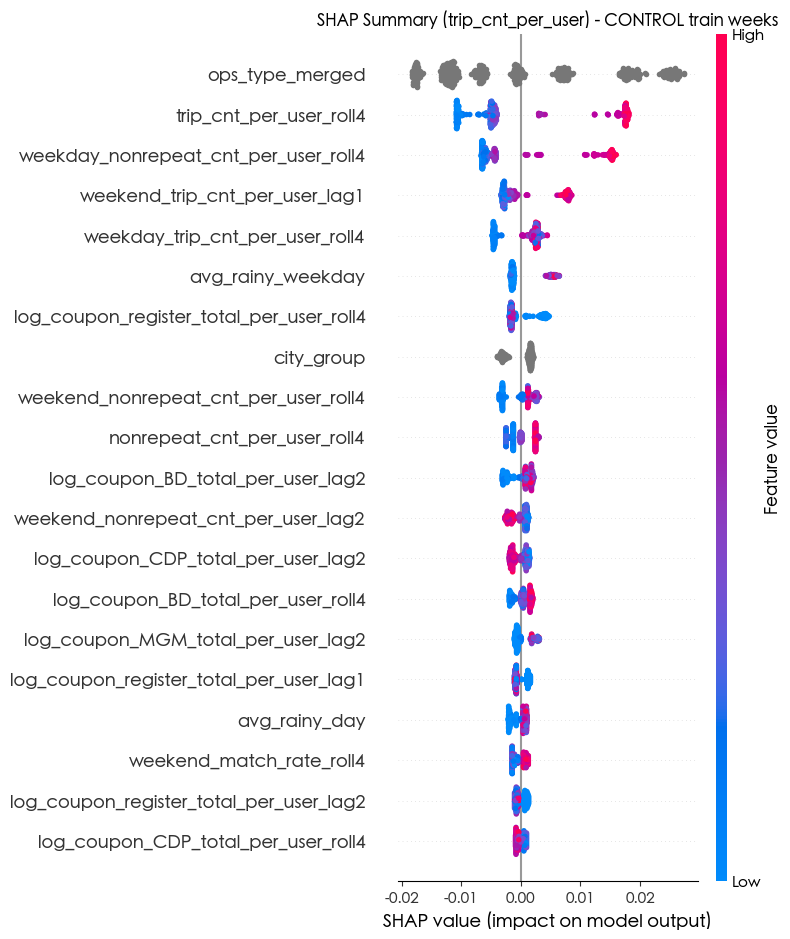

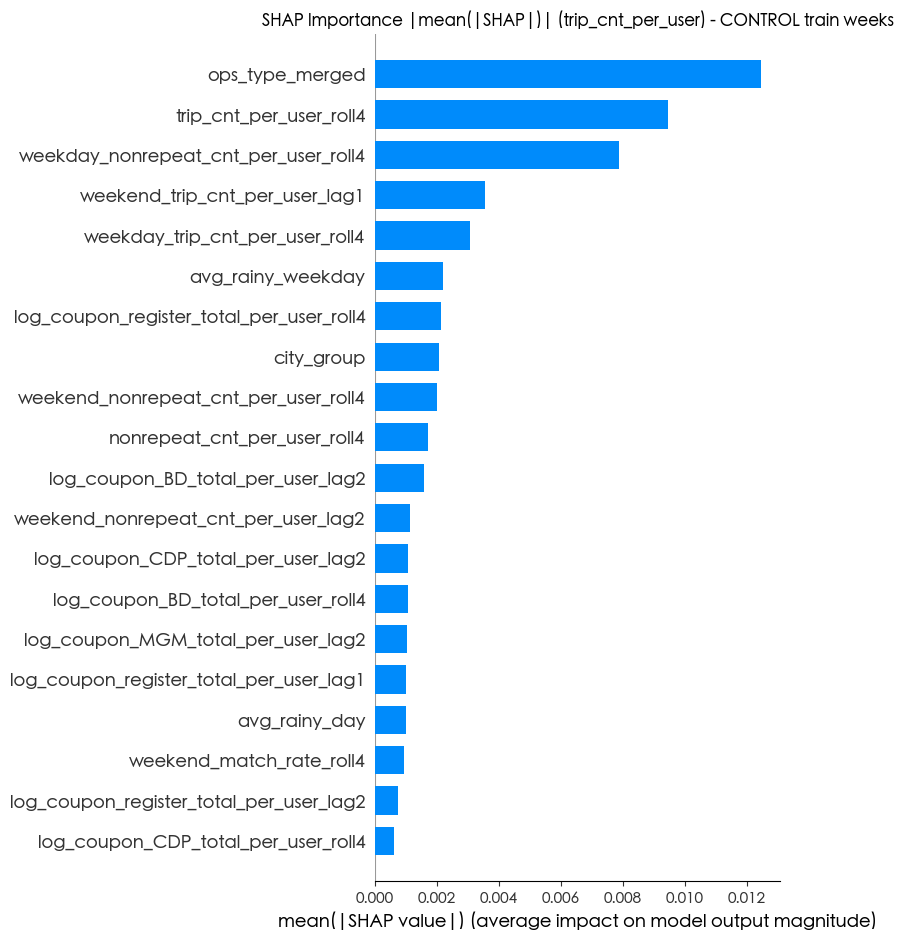

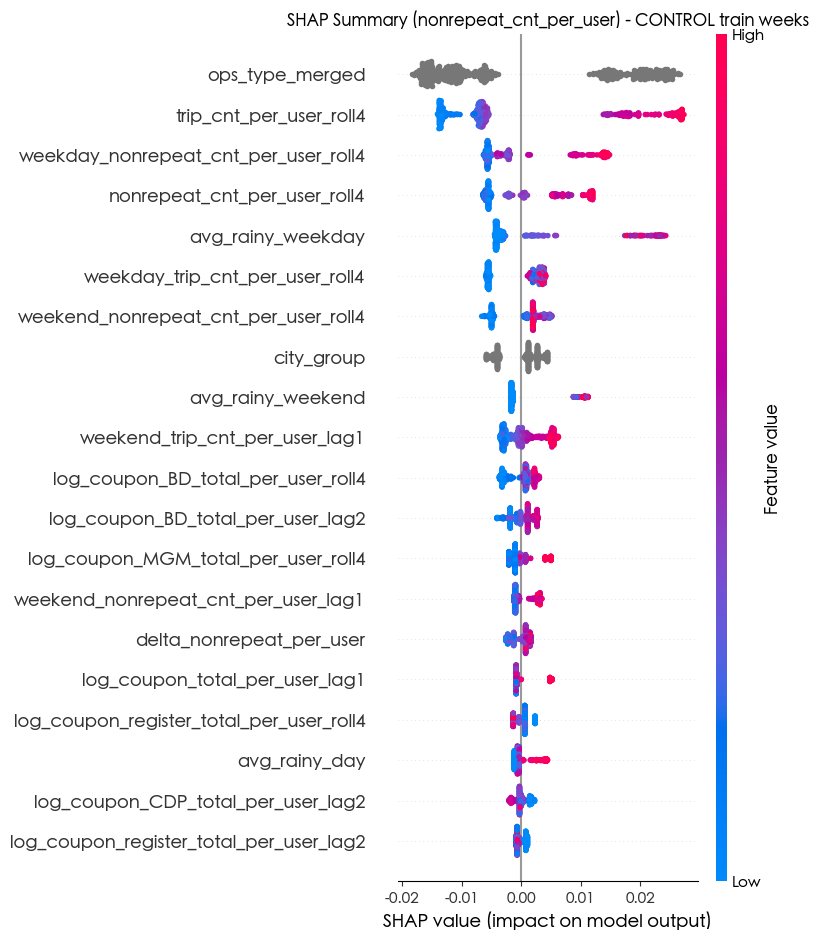

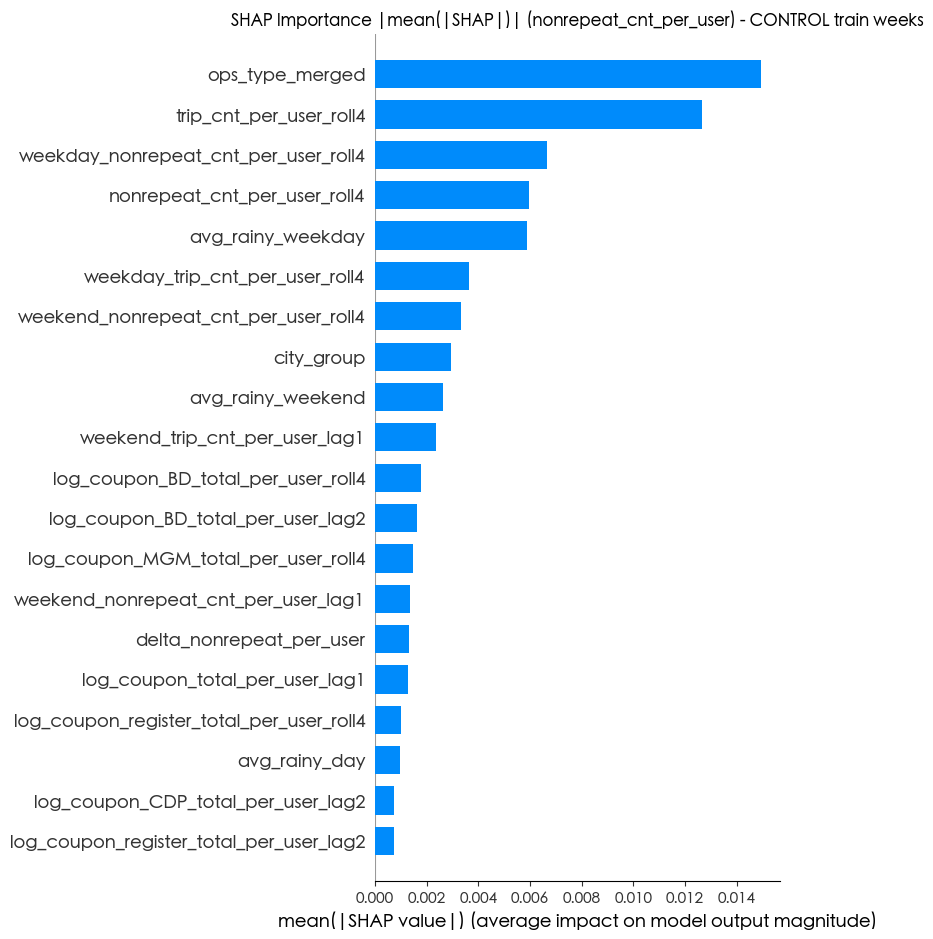

In [1]:
# ==========================================
# CONTROL: Global model (LGBM) + SHAP only
# Target week: 2026-01-05
# - Keep your CONTROL pipeline (auto-cast object->category + align categories)
# - ONLY plot SHAP (no printing tables, no saving files)
# ==========================================

import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260119_control.csv"
TARGET_WEEK = "2026-01-05"

DATE_COL = "experiment_date"
Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

DROP_FEATURES = {"log1p_user_cnt", "week_idx"}
RANDOM_STATE = 42

# SHAP 計算若太慢：改小或設 None(全量)
SHAP_SAMPLE_N = 20000

# --------------------------
# Font (optional): Chinese labels
# --------------------------
def set_chinese_font():
    candidates = [
        "Noto Sans CJK TC", "Noto Sans CJK SC", "Noto Sans CJK JP",
        "PingFang TC", "Microsoft JhengHei", "Heiti TC",
        "WenQuanYi Zen Hei", "SimHei", "Arial Unicode MS",
    ]
    installed = {f.name for f in fm.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False

set_chinese_font()

# --------------------------
# Helpers
# --------------------------
def make_time_val_split(train_df, date_col, n_val_weeks=4):
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None

    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])

    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()

    if tr.empty or va.empty:
        cut = int(len(uniq_dates) * 0.8)
        cut = max(1, min(cut, len(uniq_dates) - 1))
        tr_dates = set(uniq_dates[:cut])
        va_dates = set(uniq_dates[cut:])
        tr = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(tr_dates)].copy()
        va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(va_dates)].copy()
        if tr.empty or va.empty:
            return train_df.copy(), None

    return tr, va

def assert_no_object_dtypes(X, name="X"):
    bad = X.dtypes[X.dtypes == "object"]
    if len(bad) > 0:
        raise ValueError(f"{name} still has object dtypes: {list(bad.index)}")

# --------------------------
# Load & preprocess
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
if df[DATE_COL].isna().any():
    bad = df[df[DATE_COL].isna()].head(10)
    raise ValueError(f"Found unparsable dates in {DATE_COL}. Examples:\n{bad}")

# week_idx
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

target_week = pd.to_datetime(TARGET_WEEK)
train = df[df[DATE_COL] < target_week].copy()
test  = df[df[DATE_COL] == target_week].copy()
if train.empty:
    raise ValueError("Train set is empty. TARGET_WEEK may be too early.")
if test.empty:
    raise ValueError(f"Test set is empty for week {TARGET_WEEK}. Check experiment_date values.")

# --------------------------
# Features: exclude y + drops (same as your CONTROL code)
# --------------------------
exclude = {Y1, Y2} | set(DROP_FEATURES)
feature_cols = [c for c in df.columns if c not in exclude]
if DATE_COL in feature_cols:
    feature_cols.remove(DATE_COL)

# --------------------------
# ✅ Key fix: convert ALL object cols in features to category
# and align categories between train/test/val (same as your CONTROL code)
# --------------------------
X_all = df[feature_cols].copy()

obj_cols = X_all.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    X_all[c] = X_all[c].astype("category")

cat_features = X_all.select_dtypes(include=["category"]).columns.tolist()

X_train = X_all.loc[train.index].copy()
X_test  = X_all.loc[test.index].copy()

# align categories
for c in cat_features:
    union_cats = X_all[c].cat.categories
    X_train[c] = X_train[c].cat.set_categories(union_cats)
    X_test[c]  = X_test[c].cat.set_categories(union_cats)

assert_no_object_dtypes(X_train, "X_train")
assert_no_object_dtypes(X_test, "X_test")

y1_train = train[Y1].astype(float).values
y2_train = train[Y2].astype(float).values

# --------------------------
# Val split for early stopping
# --------------------------
tr_df, va_df = make_time_val_split(train, DATE_COL, n_val_weeks=4)
X_tr = X_all.loc[tr_df.index].copy()
for c in cat_features:
    X_tr[c] = X_tr[c].cat.set_categories(X_all[c].cat.categories)

y1_tr = tr_df[Y1].astype(float).values
y2_tr = tr_df[Y2].astype(float).values

X_va = None
y1_va = y2_va = None
if va_df is not None and (not va_df.empty):
    X_va = X_all.loc[va_df.index].copy()
    for c in cat_features:
        X_va[c] = X_va[c].cat.set_categories(X_all[c].cat.categories)
    y1_va = va_df[Y1].astype(float).values
    y2_va = va_df[Y2].astype(float).values

fit_kwargs = dict(categorical_feature=cat_features)

# --------------------------
# Tuned params (CONTROL)
# --------------------------
base_params = dict(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.05,
    random_state=RANDOM_STATE,
    force_row_wise=True,
)

# Y1 trip: TR_best(Stage2_id54)
params_y1 = dict(
    num_leaves=31,
    max_depth=6,
    min_child_samples=80,
    subsample=0.9,
    colsample_bytree=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    reg_lambda=2.0,
    min_split_gain=0.0,
)

# Y2 nonrepeat: NR_best(Stage2_id21)
params_y2 = dict(
    num_leaves=31,
    max_depth=6,
    min_child_samples=50,
    subsample=0.9,
    colsample_bytree=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    reg_lambda=5.0,
    min_split_gain=0.01,
)

m_y1 = lgb.LGBMRegressor(**{**base_params, **params_y1})
m_y2 = lgb.LGBMRegressor(**{**base_params, **params_y2})

EARLY_STOP = 100

if X_va is not None:
    m_y1.fit(
        X_tr, y1_tr,
        eval_set=[(X_va, y1_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP, verbose=False)],
        **fit_kwargs
    )
    m_y2.fit(
        X_tr, y2_tr,
        eval_set=[(X_va, y2_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP, verbose=False)],
        **fit_kwargs
    )
else:
    m_y1.fit(X_train, y1_train, **fit_kwargs)
    m_y2.fit(X_train, y2_train, **fit_kwargs)

# --------------------------
# SHAP: choose sample set (use train distribution)
# --------------------------
if SHAP_SAMPLE_N is None or SHAP_SAMPLE_N >= len(X_train):
    X_shap = X_train
else:
    X_shap = X_train.sample(SHAP_SAMPLE_N, random_state=42)

# TreeExplainer
expl_y1 = shap.TreeExplainer(m_y1)
expl_y2 = shap.TreeExplainer(m_y2)

shap_values_y1 = expl_y1.shap_values(X_shap)
shap_values_y2 = expl_y2.shap_values(X_shap)

# --------------------------
# Plot SHAP: Summary (beeswarm) + Bar
# --------------------------
# Y1: trip_cnt_per_user
plt.figure()
shap.summary_plot(shap_values_y1, X_shap, show=False)
plt.title("SHAP Summary (trip_cnt_per_user) - CONTROL train weeks")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values_y1, X_shap, plot_type="bar", show=False)
plt.title("SHAP Importance |mean(|SHAP|)| (trip_cnt_per_user) - CONTROL train weeks")
plt.tight_layout()
plt.show()

# Y2: nonrepeat_cnt_per_user
plt.figure()
shap.summary_plot(shap_values_y2, X_shap, show=False)
plt.title("SHAP Summary (nonrepeat_cnt_per_user) - CONTROL train weeks")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values_y2, X_shap, plot_type="bar", show=False)
plt.title("SHAP Importance |mean(|SHAP|)| (nonrepeat_cnt_per_user) - CONTROL train weeks")
plt.tight_layout()
plt.show()

# --------------------------
# (Optional) Dependence plot example
# --------------------------
# feat = "avg_rainy_day"
# if feat in X_shap.columns:
#     plt.figure()
#     shap.dependence_plot(feat, shap_values_y1, X_shap, show=False)
#     plt.title(f"Dependence: {feat} -> SHAP (trip_cnt_per_user) [CONTROL]")
#     plt.tight_layout()
#     plt.show()
